In [1]:
# -*- coding: utf-8 -*-
from __future__ import print_function  # armonise la syntaxe de print(), avec des parentheses toujours
from __future__ import division        # eviter la division entiere: 1/2 n'est plus zero dans python2 !
from __future__ import absolute_import # 

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colorbar as cb
from matplotlib.colors import LogNorm
from time import time
import datetime

from keras.layers import Input
from keras.layers import Convolution2D, Deconvolution2D, MaxPooling2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Dense, Flatten
#from keras.layers import Reshape
from keras.models import Model
from keras.models import load_model

import lib_gyre_imagettes as lgi

Using Theano backend.


In [2]:
# variables de configuration de bas niveau
DBGOK1 = False
DBGOK2 = False
#DBGOK1 = True; DBGOK2 = True

# Flag pour activer la sauvegarde des poids apres entrainement
save_net_ok = True
#save_net_ok = False

# Flag pour activer la sauvegarde des figures
save_figs_ok = True
#save_figs_ok = False

#%% ----------------------------------------------------------------------
# repertoire de base pour la sauvegarde des reseaux (architecture, poids, ...)
net_dirname_base = 'Net'
if not os.path.isdir(net_dirname_base) :
    os.makedirs(net_dirname_base)
# ------------------------------------------------------------------------
# repertoire de base pour la sauvegarde des figures
figs_dirname_base = 'Figs'
if not os.path.isdir(figs_dirname_base) :
    os.makedirs(figs_dirname_base)
# ------------------------------------------------------------------------
# prise de l'heure et date en cours pour des effets de labeling ...
dtnow = datetime.datetime.now()
dtnowstr = datetime.datetime.strftime(dtnow,'%Y%m%dT%H%M%S')

In [3]:
#%% ------------------------------------------------------------------------
# Local functions
# ------------------------------------------------------------------------
# Exemple d'une fonction pour calculer l'erreur entre Sorties Reference (ou
# observée) et Sortie Calculee
def calc_errors(y_obs,y_ret,relative=False,verbose=False):
    n_var_obs = np.prod(y_obs.shape)     # nombre d'elements de y_obs
    #
    if np.all(y_obs.shape != y_ret.shape) :
        print('calc_errors : y_ret and y_obs should have the same size and dim')
        exit()
    #
    # Errors ----------------------
    vec_err = (y_obs - y_ret)                          # Vecteur des erreurs
    current_biais = np.sum(vec_err)/n_var_obs          # Bias = moyenne des erreurs
    current_err_quad = np.sum(vec_err * vec_err)       # Erreur Quadratique
    current_err_quad_moy = current_err_quad/n_var_obs  # Erreur quadratique moyenne
    current_rms = np.sqrt(current_err_quad_moy)        # La RMS 
    if verbose :
        print("Calcule les erreurs entre deux matrices (Obs - Ret):")
        print(" Dimensions des matrices .............. ({},{})".format(y_obs.shape, y_ret.shape))
        print(" Erreur Quadratique ................... {:.3f}".format(current_err_quad))
        print(" Erreur Quadratique Moyenne ........... {:.5}".format(current_err_quad_moy))
        print(" RMS (Root Mean Squared Error) ........ {:.5}".format(current_rms))
        print(" Bias = moyenne des erreurs ........... {:.5}".format(current_biais))
    #
    # Relative Errors --------------
    if relative :
        vec_err_rel = vec_err/y_obs                                    # Vecteur des erreurs relatives
        relative_biais = np.sum(vec_err_rel) / n_var_obs               # Biais relatif
        relative_err_quad_rel = np.sum(vec_err_rel * vec_err_rel)      # Erreur Quadratique relative
        relative_err_quad_rel_moy = relative_err_quad_rel / n_var_obs  # Erreur quadratique relative moyenne
        relative_rms = np.sqrt(relative_err_quad_rel_moy)              # La RMS relative   
        if verbose :
            print("Erreurs relatives (Err/Obs):")
            print(" Erreur Quadratique relative .......... {:.3f}".format(relative_err_quad_rel))
            print(" Erreur quadratique relative moyenne .. {:.5}".format(relative_err_quad_rel_moy))
            print(" La RMS relative  ..................... {:.5}".format(relative_rms))
            print(" Le biais relatif ..................... {:.5}".format(relative_biais))
    #
    # retour des valeurs
    if relative :
        return current_err_quad, current_err_quad_moy, current_rms, current_biais,\
                relative_err_quad_rel, relative_err_quad_rel_moy, relative_rms, relative_biais
    else :
        return current_err_quad,current_err_quad_moy,current_rms,current_biais

#Calcule de l'erreur en utilisant la methode de correlation
def calc_errors_kullback(y_obs,y_ret,verbose=False):
    n_var_obs = np.prod(y_obs.shape)
    if np.all(y_obs.shape != y_ret.shape) :
        print('calc_errors_kullback : y_ret and y_obs should have the same size and dim')
        exit()
    #Kullback error
    res=[1 if (q==0 or p==0) else p/q for p,q in zip(y_obs,y_ret)]
    vec_err_kullback = y_obs *np.log(np.abs(res))
    current_kullback = np.sum(vec_err_kullback)
    if verbose:
        print("Erreurs de Kullback:")
        print(" Erreurs de Kullback .......... {:.3f}".format(current_kullback))
    return current_kullback

#Calcule de la correlation entre les valeurs predite et les valeurs desiré
def calc_errors_corr(y_obs,y_ret,verbose=False):
    if np.all(y_obs.shape != y_ret.shape) :
        print('calc_errors_corr : y_ret and y_obs should have the same size and dim')
        exit()
    #Kullback error
    res=[1 if (q==0 or p==0) else p/q for p,q in zip(y_obs,y_ret)]
    current_correlation = np.corrcoef(y_obs.flatten(),y_ret.flatten())[0,1]
    if verbose:
        print("Erreurs de Correlation:")
        print(" Erreurs de Correlation .......... {:.3f}".format(current_correlation))
    return current_correlation

#Calcule de l'angle entre le la droite de regression lineaire des points provenant des valeurs desirer en fonction des valeurs predite avec la droite de la premiere bisectrice
def calc_errors_angle(x,y,verbose=False,current_key='CHLA'):
    X=np.mean(x)
    Y=np.mean(y)
    a=np.sum((x-X)*(y-Y))/(np.sum(x**2)-len(x)*(X**2))
    b=Y-a*X
    yy=a*x+b
    current_angle = np.arctan(abs((a-1)/(1+a)))/(np.pi/4)
    if verbose:
        print("Erreurs de l'angle par rapport a la bisectrice:")
        print(" Erreurs de l'angle par rapport a la bisectrice .......... {:.3f}".format(current_angle))
        plt.figure(figsize=(10, 10),facecolor='w')
        plt.plot(x,y,'.')
        plt.plot(x,yy, 'y-')
        plt.plot([min(x), max(x)], [min(x), max(x)], 'r-')
        #plt.xlabel('valeurs initial');
        #plt.ylabel('valeurs predite');
        plt.xlabel('Valeurs de '+current_key+' de reference');
        plt.ylabel('Sorties du PMC : '+current_key+' estimee'); 
        plt.title("Diagramme de dispersion: "+current_key+" de reference VS "+current_key+" estimee", fontsize=12);
        plt.legend(['Les predition en fonction de referants','Regression lineaire','Premiere Bisectrice'], loc='upper left');
        plt.title('Valeurs Predit VS Valeurs Desire',fontsize=10);
        plt.grid(True)
        plt.show();
    return current_angle#,a,b,yy


In [4]:
#y_out_val_array = gyre_net.predict(x_valid)
#err = calc_errors(y_valid,y_out_val_array,verbose=True) # Err sur donnees Normalisees
#err=[1 if (q==0 or p==0) else p/q for p,q in zip(y_valid,y_out_val_array)]
#vec_err_kullback = y_valid *np.log(np.abs(err))
#current_kullback = np.sum(vec_err_kullback)
#print(current_kullback)

#calc_errors_kullback(y_valid,y_out_val_array,verbose=True)
#calc_errors_corr(y_valid,y_out_val_array,verbose=True)

In [5]:
#%% ======================================================================
# parametres de configuration des donnees source a utiliser
# ========================================================================

#current_gyre_resol = "B3"
current_gyre_resol = "B9"

# nom de base du cas : cas emulant les architectures utilisees par Charles
case_base_name = "CasGyre"+current_gyre_resol

# flag pour construction l'ensemble VALID à partir de TRAIN
#VALID_SET_OK = False
VALID_SET_OK = True
valid_fraction = 1/4;  # 1/4 des donnees d'apprentissage destinees a l'ensemble de validation

# flag pour le chargement d'un ensemble TEST independant
#TEST_SET_OK = False
TEST_SET_OK = True

# Extraction des donnees:
# On genere les donnees-imagettes a partit des donnees image.
don_labels = "GYRE"
#------------------------------------------------------------------
# Mettre la bonne bibliothèque de données
datalib='../Donnees/DonneesTRIED/Gyre/data/'
# ------------------------------------------------------------------------
train_part_name = "B54V3on"+current_gyre_resol+"_20520218-20520522-48d-TRAIN";
# ------------------------------------------------------------------------
val_part_name = "B54V3on"+current_gyre_resol+"_20530218-20530523-48d-VALIDATION";
# ------------------------------------------------------------------------
test_part_name = "B54V3on"+current_gyre_resol+"_20540102-20540629-90d-TEST1";
#test_part_name = "B54V3on"+current_gyre_resol+"_20540701-20541230-90d-TEST2";
# ------------------------------------------------------------------------
# INPUT variable list (choose between 'CHLA','SST','SSH','SSS')
in_var_list = 'CHLA'
#in_var_list = 'SST'
#in_var_list = ['CHLA','SST']
#in_var_list = ['CHLA','SST','SSH','SSS']
# ------------------------------------------------------------------------
# OUTPUT variable list (choose between 'CHLA','SST','SSH','SSS')
# Le meme qu'en Entree:
out_var_list = in_var_list
# ------------------------------------------------------------------------
# Paramètres pour la normalisation par variable :
#    Méthode de normalisation. Par défaut 'normreduc': réduit les données ramenant
#    le minimum à 0 et en divisant par l'écart-type.  En réalité, il ramène le 
#    minimum à 0.01 pour éviter d'avoir de valeur d'entrée à zéro.
#    Pour des raisons de distribution des données, il peut être utile de coder par
#    le LOG une variable et ainsi améliorer sa distribution.  On peut ici
#    déclarer de coder par log10 une valeur d'entrée, le codage sera appliqué avant
#    normalisation, c'est la cas d'ailleurs pour la CHLA.
#    Enfin, il est possible d'appliquer un facteur 'std_factor' à l'écart-type
#    avant division. Les facteurs montrés ici, purement empiriques, ont été estimés
#    pour garantir d'avoir les valeurs normalises pour la plupart entre 0 et 1.
gyre_norm_params = {'CHLA': { 'method':'normreduc', 'std_factor':12, 'log':True}, 
                    'SST':  { 'method':'normreduc', 'std_factor':4 },
                    'SSH':  { 'method':'normreduc', 'std_factor':6 },
                    'SSS':  { 'method':'normreduc', 'std_factor':4.5}}
# ------------------------------------------------------------------------
# Choose the Delta T for selecting INPUT IMAGES:
# Vecteur d'indices de decalage dans le temps (t-3, t-2, t, t-1) --> [-3, -2, -1]
t_decal_in = [-3, -2, -1];  # (t-3, t-2, t-1)
# ------------------------------------------------------------------------
t_decal_out = [0];  # (t)

# ========================================================================
# parametres de configuration imagettes a extraire
# ========================================================================

# tuple de la taille des imagettes en pixels
current_archi_in_imsize = (7,7)
#
im_l_in_sz,im_c_in_sz = current_archi_in_imsize; # separe les tailles L et C (lignes et colonnes)
# ------------------------------------------------------------------------
# le pas ou "step" de mouvement des fenêtres de selection des imagettes lors du
# sous-echantillonage des image source, HORIZ et VERT, en pixels, est de:
stp_value = im_l_in_sz//2; # un pas qui correspond à la moitie de la taille des imagettes, par exemple
#stp_value = 1;
#stp_value = 10;

print("\n====================================================================")
print("                  Specifications du cas en cours")
print("====================================================================")
print("Nom de base du cas en cours ............................ ", case_base_name)
print("Nom des donnees source pour l'apprentissage ............ ", train_part_name)
print("Nom des donnees source pour la valdiation ............ ", val_part_name)
print("Nom des donnees source pour Test ....................... ", test_part_name)
print("Variable etudiee ....................................... ", in_var_list)
print("Decalage temporaire des entrees ........................ ", t_decal_in)
print("Decalage temporaire des sorties ........................ ", t_decal_out)
print("Taille des imagettes d'entree .......................... ", current_archi_in_imsize)
print("Pas de sous-echantillonage des imagettes ............... ", stp_value)




                  Specifications du cas en cours
Nom de base du cas en cours ............................  CasGyreB9
Nom des donnees source pour l'apprentissage ............  B54V3onB9_20520218-20520522-48d-TRAIN
Nom des donnees source pour la valdiation ............  B54V3onB9_20530218-20530523-48d-VALIDATION
Nom des donnees source pour Test .......................  B54V3onB9_20540102-20540629-90d-TEST1
Variable etudiee .......................................  CHLA
Decalage temporaire des entrees ........................  [-3, -2, -1]
Decalage temporaire des sorties ........................  [0]
Taille des imagettes d'entree ..........................  (7, 7)
Pas de sous-echantillonage des imagettes ...............  3


In [6]:
#%% Lecture des donnees Gyre
# Lecture donnees/images Gyre  CHLA, SST, SSH, SSS
print("\nChargement des données Gyre ..." )
gyre_data = lgi.read_gyre_data(input_datalib=datalib,input_part_name=train_part_name)
if DBGOK1 :
    # afficher, par exemple, les diferentes variables pour le jour=10
    lgi.show_data_gyre_img(gyre_data, ima_index=10)


Chargement des données Gyre ...

Reading images data from file ... ../Donnees/DonneesTRIED/Gyre/data/BaseGyre_B54V3onB9_20520218-20520522-48d-TRAIN.pklgz
Gyre data are stocked in Dictionary format:
list of variables found in gyre_data_in: ['CHLA', 'SST', 'SSH', 'SSS', 'time']

 - Key ['CHLA'] ... Dimensions: (48, 180, 270) ... Type: <type 'numpy.ndarray'>
   Data stats [Min/Max/Mean/Std] .... [0.0015174681, 10.523085, 0.33784747, 0.55452108]

 - Key ['SST'] ... Dimensions: (48, 180, 270) ... Type: <type 'numpy.ndarray'>
   Data stats [Min/Max/Mean/Std] .... [8.7146692, 25.229538, 17.297413, 4.3621826]

 - Key ['SSH'] ... Dimensions: (48, 180, 270) ... Type: <type 'numpy.ndarray'>
   Data stats [Min/Max/Mean/Std] .... [-0.67903715, 0.79508352, -3.1396685e-10, 0.24877453]

 - Key ['SSS'] ... Dimensions: (48, 180, 270) ... Type: <type 'numpy.ndarray'>
   Data stats [Min/Max/Mean/Std] .... [34.872181, 36.368073, 35.816162, 0.39929283]

 - Key ['time'] ... Dimensions: (48,) ... Type: <type

In [7]:
#%% Normalisation des donnees IN et OUT
gyre_norm_data,gyre_stat_vars = lgi.norm_gyre_images(gyre_data,
                                        in_var_list=in_var_list, out_var_list=out_var_list,
                                        norm_init_params=gyre_norm_params)


norm_gyre_images:
all_var_list: ['CHLA']
variables are arrays of 48 images of 180 x 270 pixels size

Normalizing CHLA :
local_init_norm_params {'log': True, 'method': 'normreduc', 'std_factor': 12}
Normalisation par "normreduc": reduit la distribution des donnes et normalise
parametres specifies:
 log ............... True
 normin ............ 0.01
 absmin ............ None
 std_factor ........ 12
Stats avant normalisation:
 min ............... 0.00151747
 max ............... 10.5231
 std ............... 0.554521
parametres calcules:
 st_min ............ -2.81888
 st_std ............ 0.313275
 st_std_after_min .. -2.81888
Stats apres normalisation:
 min ............... 0.01
 max ............... 1.03174
 std ............... 0.0833333


In [8]:
#%% Extraction des imagettes de train
print("\nExtraction des imagettes {} ...".format(current_archi_in_imsize))
DD = lgi.get_gyre_imagettes(gyre_norm_data, time_data=gyre_data['time'],
                        in_var_list=in_var_list, out_var_list=out_var_list,
                        t_decal_in=t_decal_in, t_decal_out=t_decal_out,
                        stp_value=stp_value,
                        imgtt_l_size_in=im_l_in_sz,
                        imgtt_c_size_in=im_c_in_sz);

if DBGOK2 :
    # afficge une image de la variable etudiee (P;ex 'CHLA') et
    # quelques unes des imagettes decoupees:
    #lgi.show_data_and_imagettes(gyre_data,DD,ima_index=1,nl=4,nc=16)
    lgi.show_data_and_imagettes(gyre_data,DD,ima_index=10,nl=8,nc=22,notitle=True)

# ========================================================================
# Recupere les donnees x_train et y_train (imagettes)
x_train = DD['x_img_train'];       # imagettes d'Entree
#yi_train = DD['y_img_train'];      # imagettes de Sortie (pas utilisees)
y_train = DD['y_vec_train'];       # vecteur de Sortie
case_stat_params = gyre_stat_vars
case_variables = DD["case_variables"]


Extraction des imagettes (7, 7) ...

get_gyre_imagettes:

Current Gyre data stocked in Dictionary format contains:
list of variables found in gyre_data_in: ['CHLA']

 - Key ['CHLA'] ... Dimensions: (48, 1, 180, 270) ... Type: <type 'numpy.ndarray'>
   Data stats [Min/Max/Mean/Std] .... [0.0099999998, 1.03174, 0.5926851, 0.083333336]


in_var_list: ['CHLA'] <type 'list'>
variables are arrays of 48 images of 180 x 270 pixels size
Le pas de defilement est de: 
  3 pixels, verticalement (lignes), et de 
  3 pixels, horizontalement (colonnes)
prise en compte de CHLA en entree ...
prise en compte de CHLA en sortie ...
name particle= IN_CHLA_t-3_t-2_t-1-OUT_CHLA_t

Preparation for INPUT IMAGES: extracting 1 variables: ['CHLA']
firstmaprange: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
current_indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 3

In [9]:
#%% Lecture des donnees Gyre pour Valdiation
if VALID_SET_OK :
    print("\nChargement des données Gyre pour Validation ..." )
    gyre_data_val = lgi.read_gyre_data(input_datalib=datalib,input_part_name=val_part_name)
    #
    # Normalisation des donnees Validation
    print("\nNormalisation des donnees Validation ...")
    gyre_norm_data_val,gyre_stat_vars_val = lgi.norm_gyre_images(gyre_data_val,
                                            in_var_list=in_var_list, out_var_list=out_var_list,
                                            norm_stat_params=case_stat_params)   # passe les parametres stat pour une
                                                                                 # normalisation a l'identique
    #
    print("\nExtraction des imagettes Validation {} ...".format(current_archi_in_imsize))
    DD_val = lgi.get_gyre_imagettes(gyre_norm_data_val,
                        in_var_list=in_var_list, out_var_list=out_var_list,
                        t_decal_in=t_decal_in, t_decal_out=t_decal_out,
                        stp_value=stp_value,
                        imgtt_l_size_in=im_l_in_sz,
                        imgtt_c_size_in=im_c_in_sz,
                        silent=True);
    #
    # ========================================================================
    # Recupere les donnees x_test et y_test (imagettes)
    x_valid = DD_val['x_img_train'];     # imagettes d'Entree
    #yi_test = DD_test['y_img_train'];    # imagettes de Sortie (pas utilisees)
    y_valid = DD_val['y_vec_train'];     # vecteur de Sortie
    case_stat_params_val = gyre_stat_vars_val
    case_variables_val = DD_val["case_variables"]




Chargement des données Gyre pour Validation ...

Reading images data from file ... ../Donnees/DonneesTRIED/Gyre/data/BaseGyre_B54V3onB9_20530218-20530523-48d-VALIDATION.pklgz
Gyre data are stocked in Dictionary format:
list of variables found in gyre_data_in: ['CHLA', 'SST', 'SSH', 'SSS', 'time']

 - Key ['CHLA'] ... Dimensions: (48, 180, 270) ... Type: <type 'numpy.ndarray'>
   Data stats [Min/Max/Mean/Std] .... [0.00068935583, 10.867112, 0.33653641, 0.54366821]

 - Key ['SST'] ... Dimensions: (48, 180, 270) ... Type: <type 'numpy.ndarray'>
   Data stats [Min/Max/Mean/Std] .... [8.7366467, 25.157387, 17.484945, 4.3424268]

 - Key ['SSH'] ... Dimensions: (48, 180, 270) ... Type: <type 'numpy.ndarray'>
   Data stats [Min/Max/Mean/Std] .... [-0.71852392, 0.87693089, 5.2327809e-11, 0.24583417]

 - Key ['SSS'] ... Dimensions: (48, 180, 270) ... Type: <type 'numpy.ndarray'>
   Data stats [Min/Max/Mean/Std] .... [34.909058, 36.408276, 35.832329, 0.40403187]

 - Key ['time'] ... Dimensions: 

In [10]:
case_stat_params

{'CHLA': {'absmin': 0.0015174681,
  'log': True,
  'min': -2.8188803,
  'normin': 0.01,
  'std': 0.31327477,
  'std_after_min': 0.31327471,
  'std_factor': 12}}

In [11]:
case_stat_params_val

{'CHLA': {'absmin': 0.0015174681,
  'log': True,
  'min': -2.8188803,
  'normin': 0.01,
  'std': 0.31327477,
  'std_after_min': 0.31327471,
  'std_factor': 12}}

In [12]:
#%% Lecture des donnees Gyre pour TEST
if TEST_SET_OK :
    print("\nChargement des données Gyre pour TEST ..." )
    gyre_data_test = lgi.read_gyre_data(input_datalib=datalib,input_part_name=test_part_name)
    #
    # Normalisation des donnees TEST
    print("\nNormalisation des donnees TEST ...")
    gyre_norm_data_test,gyre_stat_vars_test = lgi.norm_gyre_images(gyre_data_test,
                                            in_var_list=in_var_list, out_var_list=out_var_list,
                                            norm_stat_params=case_stat_params)   # passe les parametres stat pour une
                                                                                 # normalisation a l'identique
    #
    print("\nExtraction des imagettes TEST {} ...".format(current_archi_in_imsize))
    DD_test = lgi.get_gyre_imagettes(gyre_norm_data_test,
                        in_var_list=in_var_list, out_var_list=out_var_list,
                        t_decal_in=t_decal_in, t_decal_out=t_decal_out,
                        stp_value=stp_value,
                        imgtt_l_size_in=im_l_in_sz,
                        imgtt_c_size_in=im_c_in_sz,
                        silent=True);
    #
    # ========================================================================
    # Recupere les donnees x_test et y_test (imagettes)
    x_test = DD_test['x_img_train'];     # imagettes d'Entree
    #yi_test = DD_test['y_img_train'];    # imagettes de Sortie (pas utilisees)
    y_test = DD_test['y_vec_train'];     # vecteur de Sortie


Chargement des données Gyre pour TEST ...

Reading images data from file ... ../Donnees/DonneesTRIED/Gyre/data/BaseGyre_B54V3onB9_20540102-20540629-90d-TEST1.pklgz
Gyre data are stocked in Dictionary format:
list of variables found in gyre_data_in: ['CHLA', 'SST', 'SSH', 'SSS', 'time']

 - Key ['CHLA'] ... Dimensions: (90, 180, 270) ... Type: <type 'numpy.ndarray'>
   Data stats [Min/Max/Mean/Std] .... [0.00043416326, 10.90532, 0.27378508, 0.45448756]

 - Key ['SST'] ... Dimensions: (90, 180, 270) ... Type: <type 'numpy.ndarray'>
   Data stats [Min/Max/Mean/Std] .... [8.7479086, 25.993843, 17.929585, 4.3189893]

 - Key ['SSH'] ... Dimensions: (90, 180, 270) ... Type: <type 'numpy.ndarray'>
   Data stats [Min/Max/Mean/Std] .... [-0.73907018, 0.80077535, 1.1163266e-10, 0.2432227]

 - Key ['SSS'] ... Dimensions: (90, 180, 270) ... Type: <type 'numpy.ndarray'>
   Data stats [Min/Max/Mean/Std] .... [34.74107, 36.423985, 35.81353, 0.41567215]

 - Key ['time'] ... Dimensions: (90,) ... Type:

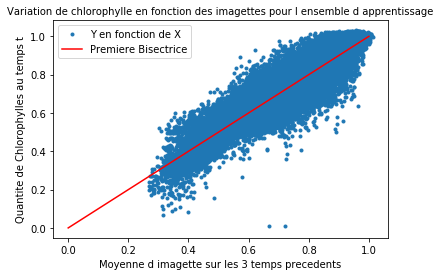

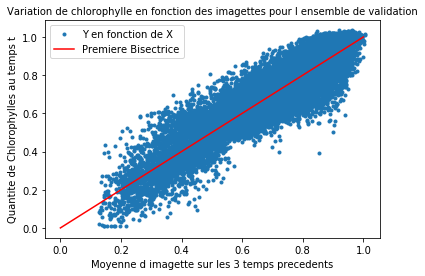

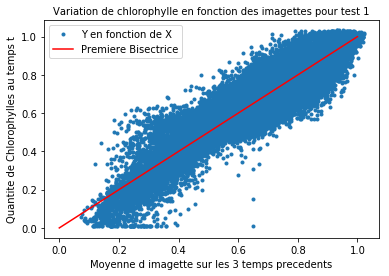

In [13]:
x_train_mean=map(lambda x: np.mean(x_train[x,:,:,:]),range(x_train.shape[0]))
plt.plot(x_train_mean,y_train,'.')
plt.plot([0.0, 1.0], [0.0, 1.0], 'r-')
plt.xlabel('Moyenne d imagette sur les 3 temps precedents');
plt.ylabel('Quantite de Chlorophylles au temps t');
plt.legend(['Y en fonction de X','Premiere Bisectrice'], loc='upper left');
plt.title('Variation de chlorophylle en fonction des imagettes pour l ensemble d apprentissage',fontsize=10);
plt.show();

x_valid_mean=map(lambda x: np.mean(x_valid[x,:,:,:]),range(x_valid.shape[0]))
plt.plot(x_valid_mean,y_valid,'.')
plt.plot([0.0, 1.0], [0.0, 1.0], 'r-')
plt.xlabel('Moyenne d imagette sur les 3 temps precedents');
plt.ylabel('Quantite de Chlorophylles au temps t');
plt.legend(['Y en fonction de X','Premiere Bisectrice'], loc='upper left');
plt.title('Variation de chlorophylle en fonction des imagettes pour l ensemble de validation',fontsize=10);
plt.show();

x_test_mean=map(lambda x: np.mean(x_test[x,:,:,:]),range(x_test.shape[0]))
plt.plot(x_test_mean,y_test,'.')
plt.plot([0.0, 1.0], [0.0, 1.0], 'r-')
plt.xlabel('Moyenne d imagette sur les 3 temps precedents');
plt.ylabel('Quantite de Chlorophylles au temps t');
plt.legend(['Y en fonction de X','Premiere Bisectrice'], loc='upper left');
plt.title('Variation de chlorophylle en fonction des imagettes pour test 1',fontsize=10);
plt.show();


#x_test_mean=map(lambda x: np.mean(x_test[x,:,:,:]),range(x_test.shape[0]))
#plt.plot(x_test_mean,y_test,'.')
#plt.plot([0.0, 1.0], [0.0, 1.0], 'r-')
#plt.xlabel('Moyenne d imagette sur les 3 temps precedents');
#plt.ylabel('Quantite de Chlorophylles au temps t');
#plt.legend(['Y en fonction de X','Premiere Bisectrice'], loc='upper left');
#plt.title('Variation de chlorophylle en fonction des imagettes pour test 2',fontsize=10);
#plt.show();

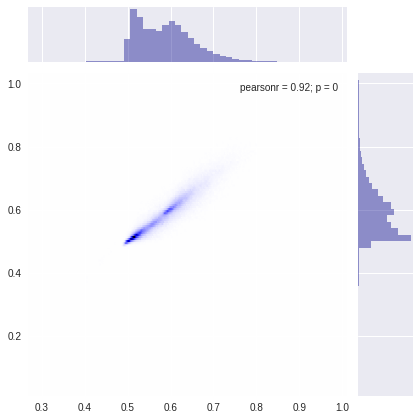

In [58]:
#from scipy.stats import kendalltau
#from scipy.stats import spearmanr
from scipy.stats import pearsonr
import seaborn as sns

#print(np.corrcoef(np.array(x_train_mean), y_train.flatten()))
#print(kendalltau(np.array(x_train_mean), y_train.flatten()))
#sns.set(style="ticks")
sns.jointplot(np.array(x_train_mean), y_train.flatten(), kind="hex", stat_func=pearsonr, color="#00008B")
sns.plt.show()

In [59]:
np.array(np.exp(x_train_mean))

array([ 1.81190832,  1.79019461,  1.78677867, ...,  2.42124352,
        2.40687819,  2.33850561])

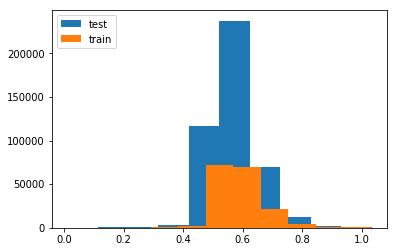

In [27]:
plt.hist(x_test[:,1,4,4])
plt.hist(x_train[:,1,4,4])
plt.legend(['test','train'], loc='upper left');
plt.show()


In [61]:
x_train.shape

(229680, 3, 7, 7)

In [28]:
# ------------------------------------------------------------------------
#%% ajout du nom
base_name_ext = DD['base_name_in_ext']+"-"+DD['base_name_outv_ext']+"-"+DD['base_name_step_ext']
extraction_base_name = train_part_name+'_'+base_name_ext

print("OUTPUT data file base name:\n ", extraction_base_name)

# Recupere les parametres du cas
case_params = DD['case_params']
case_t_decal_in = case_params['t_decal_in'];
case_t_decal_out = case_params['t_decal_out'];
case_t_decal_in_labels = case_params['t_label_in'];
case_t_decal_out_labels = case_params['t_label_out'];
case_t_decal_in_list_labels = case_params['t_label_in_list'];
case_t_decal_out_list_labels = case_params['t_label_out_list'];

print("\nINPUT data : repartition en Train :")
x_train, _, i_train, i_valid = lgi.get_training_sets(x_train,random_perm=True,
                                                               valid_ratio=valid_fraction);
# ------------------------------------------------------------------------
# (2) utilise les indices pour separer les Sorties en Y_TRAIN et Y_VALID
print("\nOUTPUT data : repartition en Train:")
y_train, _ = lgi.get_training_sets(y_train,repartition_index=(i_train, i_valid))



if VALID_SET_OK :
    # Separation en ensembles: Train, Valid
    # ------------------------------------------------------------------------
    # (1) separation des Entrees en X_TRAIN et X_VALID et creation des indices
    print("\nINPUT data : repartition en Valid :")
    _, x_valid, i_train, i_valid = lgi.get_training_sets(x_valid,random_perm=True,
                                                               valid_ratio=valid_fraction);
    # ------------------------------------------------------------------------
    # (2) utilise les indices pour separer les Sorties en Y_TRAIN et Y_VALID
    print("\nOUTPUT data : repartition en Valid:")
    _, y_valid = lgi.get_training_sets(y_valid,repartition_index=(i_train, i_valid))
else :
    print("\nPas de separation en Train, Valid ... Uniquement Train !!")
# Shape and type of the data
print('\nCurrent Shape and type of data:')
print(' - Train input data shape type ............. ', x_train.shape, x_train.dtype)
print(' - Train output data shape type ............ ', y_train.shape, y_train.dtype)
print(" - MIN et MAX des donnees Train d'entree ... ", np.min(x_train), np.max(x_train))
print(' - MIN et MAX des donnees Train de sortie .. ', np.min(y_train), np.max(y_train))
if VALID_SET_OK :
    print(' -------------------------------------------------')
    print(' - Valid inputdata shape type .............. ', x_valid.shape, x_valid.dtype)
    print(' - Valid output data shape type ............ ', y_valid.shape, y_valid.dtype)
    print(" - MIN et MAX des donnees Valid d'entree ... ", np.min(x_valid), np.max(x_valid))
    print(' - MIN et MAX des donnees Valid de sortie .. ', np.min(y_valid), np.max(y_valid))
if TEST_SET_OK :
    print(' -------------------------------------------------')
    print(' - Test input data shape type .............. ', x_test.shape,  x_test.dtype)
    print(' - Test output data shape type ............. ', y_test.shape,  y_test.dtype)
    print(" - MIN et MAX des donnees Test d'entree .... ", np.min(x_test), np.max(x_test))
    print(' - MIN et MAX des donnees Test de sortie ... ', np.min(y_test), np.max(y_test))

OUTPUT data file base name:
  B54V3onB9_20520218-20520522-48d-TRAIN_IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px

INPUT data : repartition en Train :
get_training_sets: dimension de l'array: -  (172260, 3, 7, 7)
Repartie les  172260 patterns selon des fractions:
 -  129195  pour l'ensemble d'apprentissage.
 -  43065  pour l'ensemble de validation.

OUTPUT data : repartition en Train:
get_training_sets: dimension de l'array: -  (172260, 1)
Repartie les  172260 patterns selon les indices donnes :
 -  129195  pour l'ensemble d'apprentissage.
 -  43065  pour l'ensemble de validation.

INPUT data : repartition en Valid :
get_training_sets: dimension de l'array: -  (57420, 3, 7, 7)
Repartie les  57420 patterns selon des fractions:
 -  43065  pour l'ensemble d'apprentissage.
 -  14355  pour l'ensemble de validation.

OUTPUT data : repartition en Valid:
get_training_sets: dimension de l'array: -  (57420, 1)
Repartie les  57420 patterns selon les indices donnes :
 -  43065  pour l'ensemble d'ap

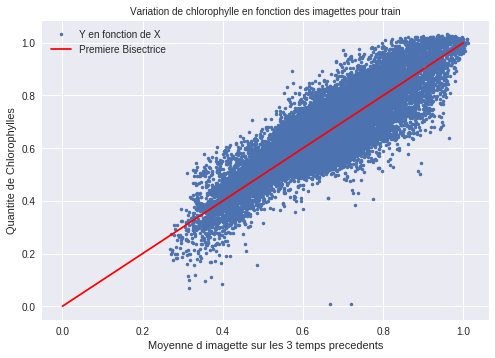

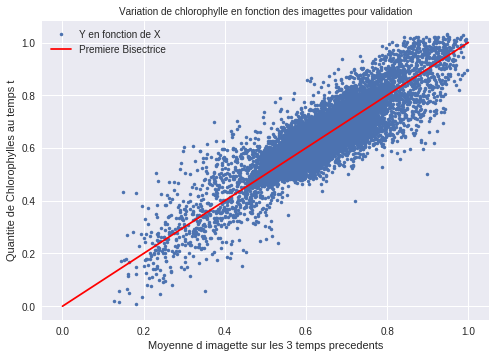

In [63]:
x_train_mean=map(lambda x: np.mean(x_train[x,:,:,:]),range(x_train.shape[0]))
plt.plot(x_train_mean,y_train,'.')
plt.plot([0.0, 1.0], [0.0, 1.0], 'r-')
plt.xlabel('Moyenne d imagette sur les 3 temps precedents');
plt.ylabel('Quantite de Chlorophylles');
plt.legend(['Y en fonction de X','Premiere Bisectrice'], loc='upper left');
plt.title('Variation de chlorophylle en fonction des imagettes pour train',fontsize=10);
plt.show();

x_valid_mean=map(lambda x: np.mean(x_valid[x,:,:,:]),range(x_valid.shape[0]))
plt.plot(x_valid_mean,y_valid,'.')
plt.plot([0.0, 1.0], [0.0, 1.0], 'r-')
plt.xlabel('Moyenne d imagette sur les 3 temps precedents');
plt.ylabel('Quantite de Chlorophylles au temps t');
plt.legend(['Y en fonction de X','Premiere Bisectrice'], loc='upper left');
plt.title('Variation de chlorophylle en fonction des imagettes pour validation',fontsize=10);
plt.show();


x_test_mean=map(lambda x: np.mean(x_test[x,:,:,:]),range(x_test.shape[0]))
plt.plot(x_test_mean,y_test,'.')
plt.plot([0.0, 1.0], [0.0, 1.0], 'r-')
plt.xlabel('Moyenne d imagette sur les 3 temps precedents');
plt.ylabel('Quantite de Chlorophylles au temps t');
plt.legend(['Y en fonction de X','Premiere Bisectrice'], loc='upper left');
plt.title('Variation de chlorophylle en fonction des imagettes pour test 1',fontsize=10);
plt.show();

In [29]:
#%%==============================================================
#  ============ PARAMETRAGE DU PMC ET APPRENTISSAGE ============= 
#  --------------------------------------------------------------
#
# Nombre de neurones cachees:
n_hid=30;             # Nombre de neurones caches : UNE couche cachee (4471 parametres)
#n_hid=[28,11];        # Nombre de neurones caches : DEUX couches cachees (4475 parametres)
#
# Fonction d'activation des neurones pour la/les couche cachee et pour la couche de sortie:
f_hid='tanh'    # pour couches cachees: type sigmoide variant entre -1 et 1
#f_hid='sigmoid' # pour couches cachees: sigmoide variant entre 0 et 1
#f_hid='relu'    # pour couches cachees: 0 pour negatifs, lineaire pour > 0
f_out='linear'  # pour couche de sortie: lineaire partout
#
# Methode d'initialisation des poids
#init_wei = 'uniform'
#init_wei = 'lecun_uniform'
#init_wei = 'he_normal'
#init_wei = 'he_uniform'
init_wei = 'glorot_uniform'

input_shape = x_train.shape[1:]    # dimensions des entrees
input_dim = np.prod(input_shape)   # nombre de cellules en entree
output_shape = y_train.shape[1:]   # dimensions des sorties
output_dim = np.prod(output_shape) # nombre de cellules en sortie
n_train_don = x_train.shape[0]     # nombre de donnees TRAIN

# Composition du reseau:
# - Couche d'Entree
input_layer = Input(shape=input_shape) # (3) ou autre ... les dimensions des donnees diffusiometre
flatten_input = Flatten()(input_layer)

nx=7
ny=7
in_out_neurons = nx*ny
n_feat = 16
filter_size=3

#,border_mode='same' ou valid
#TimeDistributed(
gyre_net = Sequential()
x_train2=x_train
x_train2=x_train2.reshape([x_train2.shape[0],3,1,nx,ny])
x_valid2=x_valid
x_valid2=x_valid2.reshape([x_valid2.shape[0],3,1,nx,ny])
x_test2=x_test
x_test2=x_test2.reshape([x_test2.shape[0],3,1,nx,ny])


gyre_net.add(TimeDistributed(Convolution2D(n_feat,filter_size,filter_size,activation='relu'),input_shape=(3,1,nx,ny)))
gyre_net.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
gyre_net.add(TimeDistributed(Convolution2D(n_feat,2,2,activation='relu')))
gyre_net.add(TimeDistributed(Flatten()))
gyre_net.add(LSTM(output_dim=3,activation='tanh',return_sequences=True))
gyre_net.add(LSTM(output_dim=3,activation='tanh',return_sequences=False))
#gyre_net.add(Flatten())

#gyre_net.add(Flatten())
#gyre_net.add(Convolution2D(n_feat,2,2,activation='relu'))
#gyre_net.add(MaxPooling2D(pool_size=(2, 2)))


#gyre_net.add(TimeDistributed(Flatten()))
#gyre_net.add(TimeDistributed(Dense(n_hid,activation=f_hid)))
#gyre_net.add(LSTM(output_dim=3,return_sequences=False))
#gyre_net.add(TimeDistributed(Flatten()))
#gyre_net.add(TimeDistributed(Dense(output_dim=10,activation=f_out)))


gyre_net.add(Dense(output_dim=1,activation=f_out))
#gyre_net.add(Activation("relu"))
#gyre_net.add(Reshape((n_feat,nx,ny)))
#gyre_net.add(Convolution2D(1,filter_size,filter_size,border_mode='same'))
#gyre_net.add(Activation("linear"))
#gyre_net.add(Flatten())


#conv maxpooling dense 
#gyre_net = Sequential()
#gyre_net.add(Convolution2D(n_feat,filter_size,filter_size,input_shape=(3,nx,ny),activation='relu'))
#gyre_net.add(MaxPooling2D(pool_size=(5, 5)))
#gyre_net.add(Flatten())
#gyre_net.add(Dense(output_dim=1,activation=f_out))






# - Couche(s) Cachee(s)
if type(n_hid) == int : # un scalair entier
    # SI UNE seule couche cachee
    case_archi_label = 'D1-'+str(input_dim)+"x"+str(n_hid)
    # "hidden" is the encoded representation of the input
    current_layer = Dense(n_hid, activation=f_hid, init=init_wei)(flatten_input)
elif type(n_hid) == list :
    # SI PLUSSIEURS couches cachees
    case_archi_label = 'D2-'+str(input_dim)
    current_layer = flatten_input
    for hid_dim in n_hid :
        case_archi_label += "x"+str(hid_dim)
        current_layer = Dense(hid_dim, activation=f_hid, init=init_wei)(current_layer)
else :
    print("*** Erreur: cas non considere): N_HID n'est pas un scalaire entier ni une liste a deux elements ***")
    
#exemple   
#x=input..
#y=conv()(x)
#y=dense()(y)

# - Couche de Sortie
case_archi_label += "x"+str(output_dim)
output_layer = Dense(output_dim, activation=f_out, init=init_wei)(current_layer)


# Sommaire de l'architecture du Modele: couches, parametres, ...
gyre_net.summary()

# Parametres de performance et optimisation du modele
# ----------------------------------------
#optimizer='adadelta'
#optimizer='nadam'
optimizer='rmsprop'   # <== CELUI-CI SEMBLE DONNER DES MEILLEURS RESULTATS ... !!!
#optimizer='sgd'
# ----------------------------------------
#loss='binary_crossentropy'
loss='mean_squared_error' ###!!! <<== ... AVEC CECI

# Compilation du modele
gyre_net.compile(optimizer=optimizer, loss=loss)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
timedistributed_5 (TimeDistribut (None, 3, 16, 5, 5)   160         timedistributed_input_2[0][0]    
____________________________________________________________________________________________________
timedistributed_6 (TimeDistribut (None, 3, 16, 2, 2)   0           timedistributed_5[0][0]          
____________________________________________________________________________________________________
timedistributed_7 (TimeDistribut (None, 3, 16, 1, 1)   1040        timedistributed_6[0][0]          
____________________________________________________________________________________________________
timedistributed_8 (TimeDistribut (None, 3, 16)         0           timedistributed_7[0][0]          
___________________________________________________________________________________________

In [30]:
#%% composition du nom du cas
case_name = case_base_name+"_"+case_archi_label+"-"+don_labels+"-"+base_name_ext
#case_name += "-"+dtnowstr

print("Auto-encodeur ", don_labels)
print('Nom du cas de base  ....................... ', case_name)
print("-- dimmension matricielle des entrees ..... ",input_shape, "- sans compter le nombre d'elements.")
print("   nombre de cellules en entree (a plat) .. ",input_dim)
print("-- dimmension matricielle des sorties ..... ",output_shape, "- sans compter le nombre d'elements.")
print("   nombre de cellules en sortie ........... ",output_dim)
if type(n_hid) == int : # une couche cachee
       print("-- taille de la couche cachee ............. ",n_hid)
elif type(n_hid) == list : # plusieurs couches cachees
    for ihid in range(len(n_hid)) :
       print("-- taille de la couche cachee "+str(ihid)+" ........... ",n_hid[ihid])
print("-- facteur de compression ................. ",input_dim/n_hid)
print("-- nombre de donnees ...................... ",n_train_don)
# ----------------------------------------------------------------------
# repertoire local de sauvegarde des reseaux (architecture, poids, ...)
net_dirname = net_dirname_base+os.path.sep+case_name
if not os.path.isdir(net_dirname) :
    os.makedirs(net_dirname)
# ------------------------------------------------------------------------
# repertoire local de sauvegarde des figures
figs_dirname = figs_dirname_base+os.path.sep+case_name
if not os.path.isdir(figs_dirname) :
    os.makedirs(figs_dirname)

Auto-encodeur  GYRE
Nom du cas de base  .......................  CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px
-- dimmension matricielle des entrees .....  (3, 7, 7) - sans compter le nombre d'elements.
   nombre de cellules en entree (a plat) ..  147
-- dimmension matricielle des sorties .....  (1,) - sans compter le nombre d'elements.
   nombre de cellules en sortie ...........  1
-- taille de la couche cachee .............  30
-- facteur de compression .................  4.9
-- nombre de donnees ......................  129195


In [31]:
#%% Pour recupération d'un modèle déjà entrainé.  Affiche la liste de fichiers
# de poids existants, pour aider à choisir le ficher du modele déjà entrainé
if 1:
    # affiche les fichiers de poids disponibles
    #nom_cas = case_name
    print("Liste de fichiers Net deja entrainees pour le cas ...\n <"+case_name+">  :")
    lgi.list_dir('.',regexp='*'+case_name+'*',silent=True)
    lgi.list_dir(net_dirname,regexp='*'+case_name+'*',title="Current Net files :",silent=True)

Liste de fichiers Net deja entrainees pour le cas ...
 <CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px>  :

Current Net files :
 CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-70ep-bs500CNN-LSTM-70.h5
 CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-30ep-bs500CNN.h5
 CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-50ep-bs500.h5
 CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-50ep-bs500CNN_nouveau.h5
 CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-50ep-bs500CNN.h5
 CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-100ep-bs500.h5
 CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-200ep-bs500CNN_nouveau_1000.h5
 CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-50ep-bs500CNN-LSTM.h5
 CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-50ep-bs500CNN_only.h5
 C

In [32]:
# recupere un modele déja entraine
if 1 :
    # identical to the previous one
    print("recupere un modele ",don_labels, "deja entraine...")
    # Nom du fichier SANS l'extension '.h5':
    # Cas D1:
    current_case_name = 'CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-50ep-bs500CNN_nouveau'
#    current_case_name = 'CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-200ep-bs500CNN_nouveau_1000'

    #current_case_name = 'CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-200ep-bs500'
    #current_case_name = 'CasGyreB9_D1-147x35x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-500ep-bs500'
    # Cas D2:
    #current_case_name = 'CasGyreB9_D2-147x28x11x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-200ep-bs500'
    #current_case_name = 'CasGyreB9_D2-147x28x11x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-2000ep-bs500'
    gyre_net = load_model(net_dirname+os.path.sep+current_case_name+'.h5')
    gyre_net.summary()

recupere un modele  GYRE deja entraine...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
timedistributed_33 (TimeDistribu (None, 3, 16, 5, 5)   160         timedistributed_input_3[0][0]    
____________________________________________________________________________________________________
timedistributed_34 (TimeDistribu (None, 3, 16, 2, 2)   0           timedistributed_33[0][0]         
____________________________________________________________________________________________________
timedistributed_35 (TimeDistribu (None, 3, 16, 1, 1)   1040        timedistributed_34[0][0]         
____________________________________________________________________________________________________
timedistributed_36 (TimeDistribu (None, 3, 16)         0           timedistributed_35[0][0]         
_________________________________________________

In [20]:
# indice du nombre de sessions d'apprentissage executees
training_sessions = 0

if 0 :
    #nb_epochs = 10; batch_size = 500  # parametres a adapter selon le nombre de donnees
    nb_epochs = 200; batch_size = 500
    #nb_epochs = 200; batch_size = 500 # sur 71456 donnees de Train ...
    #nb_epochs = 500; batch_size = 500
    #nb_epochs = 2000; batch_size = 500

    print("Training "+don_labels+", "+str()+" epochs (batch_size="+str(batch_size)+"),",
          "with case ",case_name,"...")
    t0 = time()
    if VALID_SET_OK :
        H = gyre_net.fit(x_train2, y_train,
                            nb_epoch=nb_epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(x_valid2, y_valid),
                            verbose=1)
    else :
        H = gyre_net.fit(x_train2, y_train,
                            nb_epoch=nb_epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            verbose=1)
    print(" --> training sesion for {} epochs (bs:{}) last for {:.1f}s".format(nb_epochs,batch_size,time()-t0));
        
    training_sessions += 1
    if training_sessions > 1 :
        current_case_name = case_name+"-{}ep-bs{}".format(nb_epochs,batch_size)+\
            '-TS{0:02d}'.format(training_sessions)
    else :
        current_case_name = case_name+"-{}ep-bs{}".format(nb_epochs,batch_size)

    # Sauvegarde du Modele (reseau et poids), SI save_net_ok EST ACTIVE
    if save_net_ok :
        net_filename = current_case_name
        print("sauvegarde du modele (net) dans\n ",net_filename, "...")
        gyre_net.save(net_dirname+os.path.sep+net_filename+'CNN_nouveau_1000.h5')  # creates a HDF5 file 'my_model.h5'
        #
        print("Current case Net files :")
        lgi.list_dir(net_dirname,regexp=net_filename+'*.h5',longlist=True)
    else :
        print(" ** sauvegarde du modele (net) inactive. Modele non sauve **")

Training GYRE,  epochs (batch_size=500), with case  CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px ...
Train on 172260 samples, validate on 57420 samples
Epoch 1/200
172260/172260 [==============================] - 12s - loss: 4.0543e-04 - val_loss: 4.8664e-04

Calcule les erreurs entre deux matrices (Obs - Ret):
 Dimensions des matrices .............. ((14355, 1),(14355, 1))
 Erreur Quadratique ................... 7.413
 Erreur Quadratique Moyenne ........... 0.00051644
 RMS (Root Mean Squared Error) ........ 0.022725
 Bias = moyenne des erreurs ........... -0.011022
Erreurs relatives (Err/Obs):
 Erreur Quadratique relative .......... 87.314
 Erreur quadratique relative moyenne .. 0.0060825
 La RMS relative  ..................... 0.07799
 Le biais relatif ..................... -0.020954
Erreurs de Kullback:
 Erreurs de Kullback .......... -151.474
Erreurs de Correlation:
 Erreurs de Correlation .......... 0.973
Erreurs de l'angle par rapport a la bisectrice:
 Erreurs de l'angle par rapport a la bisectrice .......... 0.034


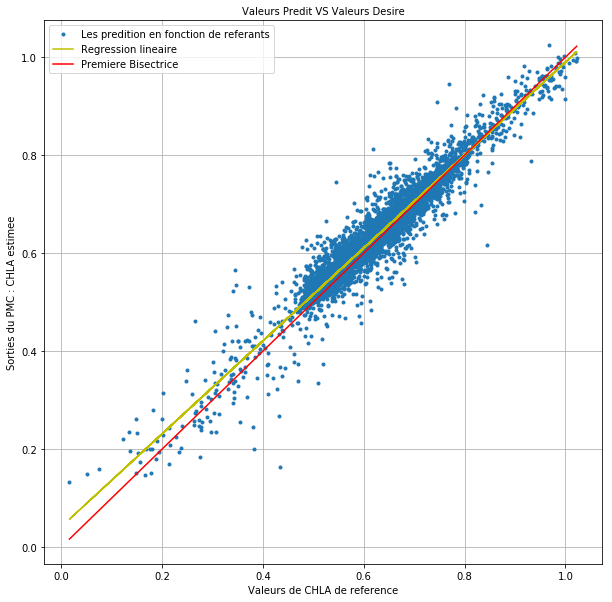

0.033716489200133065

In [33]:
y_out_val_array = gyre_net.predict(x_valid2)
calc_errors(y_valid,y_out_val_array,relative=True,verbose=True) # Err sur donnees Normalisees
calc_errors_kullback(y_valid,y_out_val_array,verbose=True)
calc_errors_corr(y_valid,y_out_val_array,verbose=True)
calc_errors_angle(y_valid,y_out_val_array,verbose=True)
#calc_errors_kullback(y_valid,y_out_val_array,verbose=True)

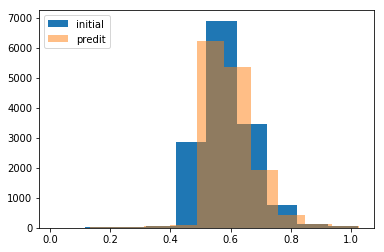

In [34]:
plt.hist(y_valid)
plt.hist(y_out_val_array,alpha = 0.5)
plt.legend(['initial','predit'], loc='upper left');
plt.show()

In [35]:
current_key=case_variables[0][0]; # premiere (et unique, normalement) variable des INPUTS, 'CHLA' ou 'SST' ou ...
current_stat_str = case_stat_params[current_key]; # paramettres pour denormalisation

current_V = lgi.denormreduc(y_out_val_array, statstruct=current_stat_str);
observed_V = lgi.denormreduc(y_valid, statstruct=current_stat_str);

Denormalisation par "denormreduc":
denormreduc: using given statstruct
log ............... True
normin ............ 0.01
x_min ............. -2.81888
std_factor ........ 12
std_after_min ..... 0.313275
Stats avant de-normalisation:
 min ............... 0.132531
 max ............... 1.02523
 std ............... 0.0843595
Stats apres de-normalisation:
 min ............... 0.00438279
 max ............... 9.94675
 std ............... 0.526064
Denormalisation par "denormreduc":
denormreduc: using given statstruct
log ............... True
normin ............ 0.01
x_min ............. -2.81888
std_factor ........ 12
std_after_min ..... 0.313275
Stats avant de-normalisation:
 min ............... 0.0158371478319
 max ............... 1.02251553535
 std ............... 0.086574656966
Stats apres de-normalisation:
 min ............... 0.00159611158574
 max ............... 9.71551497614
 std ............... 0.540221815306


Calcule les erreurs entre deux matrices (Obs - Ret):
 Dimensions des matrices .............. ((14355, 1),(14355, 1))
 Erreur Quadratique ................... 340.358
 Erreur Quadratique Moyenne ........... 0.02371
 RMS (Root Mean Squared Error) ........ 0.15398
 Bias = moyenne des erreurs ........... -0.023424
Erreurs relatives (Err/Obs):
 Erreur Quadratique relative .......... 909.368
 Erreur quadratique relative moyenne .. 0.063348
 La RMS relative  ..................... 0.25169
 Le biais relatif ..................... -0.11709
Erreurs de Kullback:
 Erreurs de Kullback .......... -224.342
Erreurs de Correlation:
 Erreurs de Correlation .......... 0.960
Erreurs de l'angle par rapport a la bisectrice:
 Erreurs de l'angle par rapport a la bisectrice .......... 0.043


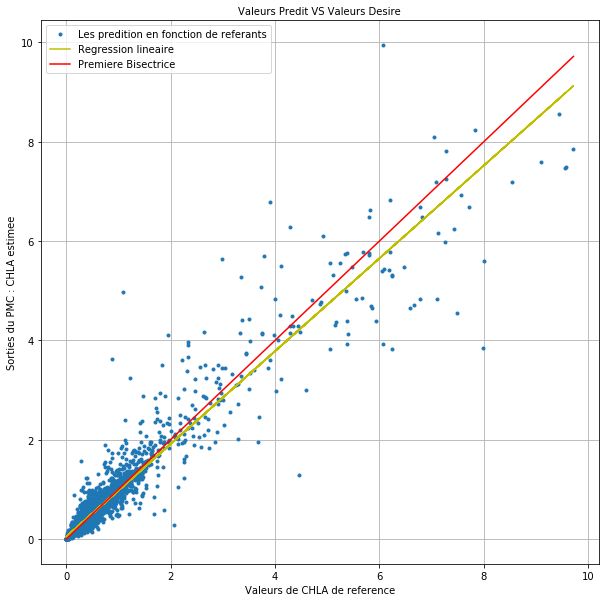

0.043125124449194259

In [36]:
calc_errors(observed_V,current_V,relative=True,verbose=True) # Err sur donnees Normalisees
calc_errors_kullback(observed_V,current_V,verbose=True)
calc_errors_corr(observed_V,current_V,verbose=True)
calc_errors_angle(observed_V,current_V,verbose=True)


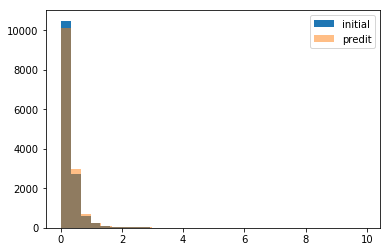

In [37]:
plt.hist(observed_V, bins=30)
plt.hist(current_V,alpha = 0.5, bins=30)
plt.legend(['initial','predit'], loc='upper right');
plt.show()

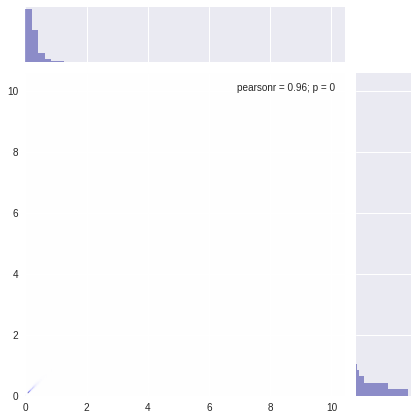

In [24]:
from scipy.stats import pearsonr
import seaborn as sns
#sns.set(style="ticks")
sns.jointplot(observed_V, current_V, kind="hex", stat_func=pearsonr, color="#00008B")
sns.plt.show()

In [38]:
# si la variable H existe, alors ...
if 'H' in vars() or 'H' in globals() :
    print("Visualisation des courbes d'erreur Train et Valid")
    train_err_hist = H.history['loss']
    fig = plt.figure(figsize=(12, 4),facecolor='w');    
    plt.subplots_adjust(hspace=0.4)
    # linear axis
    plt.subplot(121)
    if VALID_SET_OK :
        valid_err_hist = H.history['val_loss']
        (hp2,) = plt.plot(valid_err_hist,'+-r');
    (hp1,) = plt.plot(train_err_hist,'+-b');
    plt.xlabel('epochs');
    plt.ylabel('loss');
    plt.title(don_labels+': Error curves',fontsize=10);
    plt.grid(True)
    if VALID_SET_OK :
        plt.legend([hp1,hp2],['train loss','valid loss'], loc='upper right');
    # log axis
    plt.subplot(122)
    if VALID_SET_OK :
        plt.semilogy(valid_err_hist,'+-r');
    plt.semilogy(train_err_hist,'+-b');
    plt.xlabel('epochs');
    plt.ylabel('loss ([dB]');
    plt.title(don_labels+': Error curves [LOG]',fontsize=10);
    plt.grid(True)
    plt.draw();
    fig.suptitle(don_labels+': Error curves ({} epochs, bs: {})\n'.format(
                     nb_epochs,batch_size)+current_case_name,
                 fontsize=14,y=1.06);
    if save_figs_ok :
        fig_filename = figs_dirname+os.path.sep+"Fig_Perf_"+current_case_name+'.png'
        print("sauvegarde de la figure des performances dans\n ",fig_filename)
        plt.savefig(fig_filename, bbox_inches='tight')
        plt.show();
    else :
        print("** sauvegarde des figure INACTIVE, figure des performances non sauvee **")

In [39]:
#%% Passe-avant avec les donnees de Test (ou Train, si TEST_SET_OK n'est pas active)
if TEST_SET_OK :
    x_test_array = x_test2
    y_test_array = y_test
    current_test_set = 'Test'
    gyre_test = gyre_data_test
else:
    x_test_array = x_train2
    y_test_array = y_train
    current_test_set = 'Train'
    gyre_test = gyre_data

print("Feedforward pass for Testing ...")
#t0 = time()
y_out_test_array = gyre_net.predict(x_test_array)
#print(" --> forward pass takes {:.1f}s".format(time()-t0));

Feedforward pass for Testing ...


In [40]:
# denormalise des donnees ...
denorm_ok = True

# Verifie qu'il n'y ait qu'une seule variable en Entree et en Sortie et que'elle
# soit la meme en Entree qu'en Sortie  !
# Si ce n'est pas le cas il faut modifier le code ci-dessous pour denormaliser correctement les données
if len(case_variables[0]) > 1 or len(case_variables[1]) > 1 or \
    case_variables[0][0] != case_variables[1][0] :
    print("*** Attention: plusieurs variables en entree ou en sortie ou bien,   ***\n"+\
          "***            ce n'est pas la meme variable en entree qu'en sortie, ***\n"+\
          "***            Corrigez votre code pour condiderer ce cas.           ***\n")
    #break
#
current_key=case_variables[0][0]; # premiere (et unique, normalement) variable des INPUTS, 'CHLA' ou 'SST' ou ...
current_stat_str = case_stat_params[current_key]; # paramettres pour denormalisation

current_x_test = x_test_array
current_y_test = y_test_array
current_y_out_test = y_out_test_array

if denorm_ok :
    # denormalisation des donnees Input, donnees correspondantes a la premiere image
    current_X = lgi.denormreduc(current_x_test, statstruct=current_stat_str);
    observed_Y = lgi.denormreduc(current_y_test, statstruct=current_stat_str);
    retrieved_Y = lgi.denormreduc(current_y_out_test, statstruct=current_stat_str);
else :
    # PAS de denormalisation, donnees correspondantes a la premiere image
    current_X = current_x_test;
    observed_Y = current_y_test;
    retrieved_Y = current_y_out_test;

Denormalisation par "denormreduc":
denormreduc: using given statstruct
log ............... True
normin ............ 0.01
x_min ............. -2.81888
std_factor ........ 12
std_after_min ..... 0.313275
Stats avant de-normalisation:
 min ............... 0.00999999977648
 max ............... 1.03586184978
 std ............... 0.0788176043129
Stats apres de-normalisation:
 min ............... 0.00151746848225
 max ............... 10.9053241523
 std ............... 0.454639244494
Denormalisation par "denormreduc":
denormreduc: using given statstruct
log ............... True
normin ............ 0.01
x_min ............. -2.81888
std_factor ........ 12
std_after_min ..... 0.313275
Stats avant de-normalisation:
 min ............... 0.00999999977648
 max ............... 1.03339862823
 std ............... 0.0786122574714
Stats apres de-normalisation:
 min ............... 0.00151746848225
 max ............... 10.6752633847
 std ............... 0.453503551579
Denormalisation par "denormreduc":
den

In [41]:
print("Tests "+current_key+" [MIN, MAX, MEAN, STD]:")
print("Observed norm .... [{:10.6f}, {:.5f}, {:.5f}, {:.6f}]".format(np.min(current_y_test),np.max(current_y_test),np.mean(current_y_test),np.std(current_y_test)))
print("Retrieved norm ... [{:10.6f}, {:.5f}, {:.5f}, {:.6f}]".format(np.min(current_y_out_test),np.max(current_y_out_test),np.mean(current_y_out_test),np.std(current_y_out_test)))
print("Observed denorm .. [{:10.6f}, {:.4f}, {:.4f}, {:.6f}]".format(np.min(observed_Y),np.max(observed_Y),np.mean(observed_Y),np.std(observed_Y)))
print("Retrieved denorm . [{:10.6f}, {:.4f}, {:.4f}, {:.6f}]".format(np.min(retrieved_Y),np.max(retrieved_Y),np.mean(retrieved_Y),np.std(retrieved_Y)))

Tests CHLA [MIN, MAX, MEAN, STD]:
Observed norm .... [  0.010000, 1.03340, 0.57049, 0.078612]
Retrieved norm ... [  0.086488, 1.02257, 0.58145, 0.076750]
Observed denorm .. [  0.001517, 10.6753, 0.2669, 0.453504]
Retrieved denorm . [  0.002942, 9.7198, 0.2870, 0.438150]


Calcule les erreurs entre deux matrices (Obs - Ret):
 Dimensions des matrices .............. ((444048, 1),(444048, 1))
 Erreur Quadratique ................... 196.766
 Erreur Quadratique Moyenne ........... 0.00044312
 RMS (Root Mean Squared Error) ........ 0.02105
 Bias = moyenne des erreurs ........... -0.010956
Erreurs de Kullback:
 Erreurs de Kullback .......... -4677.841
Erreurs de Correlation:
 Erreurs de Correlation .......... 0.974
Erreurs de l'angle par rapport a la bisectrice:
 Erreurs de l'angle par rapport a la bisectrice .......... 0.032


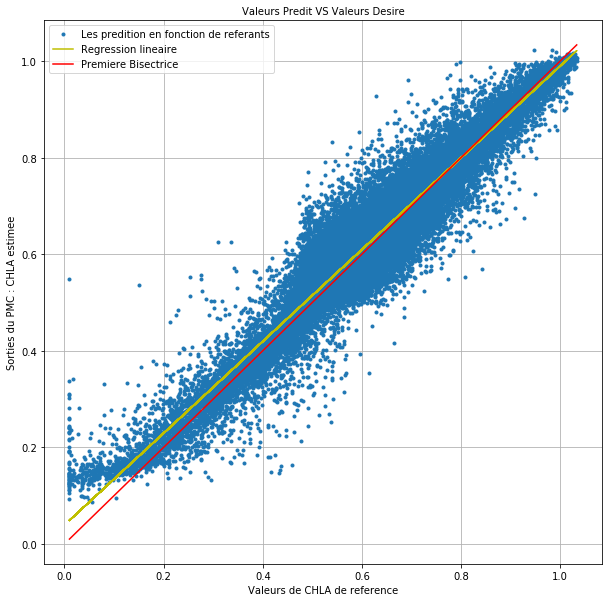

0.03233973948916035

In [42]:
calc_errors(current_y_test,current_y_out_test,verbose=True) # Err sur donnees Normalisees
calc_errors_kullback(current_y_test,current_y_out_test,verbose=True)
calc_errors_corr(current_y_test,current_y_out_test,verbose=True)
calc_errors_angle(current_y_test,current_y_out_test,verbose=True)

In [43]:
np.corrcoef(observed_Y.flatten(),retrieved_Y.flatten())[1,1]

1.0

Calcule les erreurs entre deux matrices (Obs - Ret):
 Dimensions des matrices .............. ((444048, 1),(444048, 1))
 Erreur Quadratique ................... 7380.642
 Erreur Quadratique Moyenne ........... 0.016621
 RMS (Root Mean Squared Error) ........ 0.12892
 Bias = moyenne des erreurs ........... -0.020106
Erreurs relatives (Err/Obs):
 Erreur Quadratique relative .......... 39607.877
 Erreur quadratique relative moyenne .. 0.089197
 La RMS relative  ..................... 0.29866
 Le biais relatif ..................... -0.11423
Erreurs de Kullback:
 Erreurs de Kullback .......... -6229.355
Erreurs de Correlation:
 Erreurs de Correlation .......... 0.960
Erreurs de l'angle par rapport a la bisectrice:
 Erreurs de l'angle par rapport a la bisectrice .......... 0.048


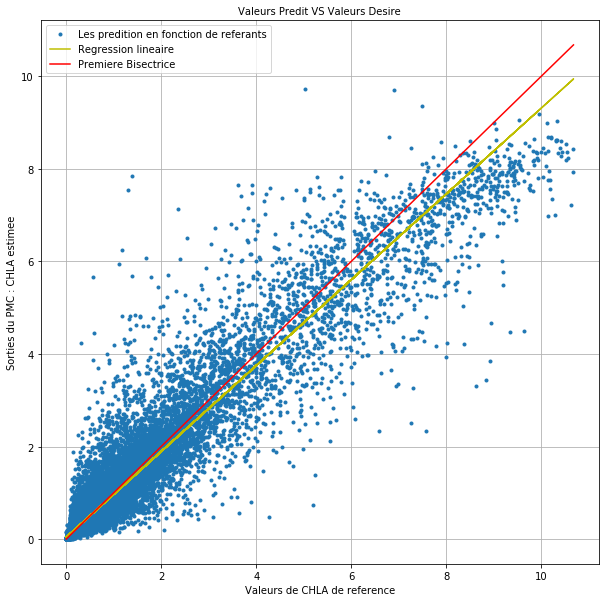

0.04801070256666682

In [44]:
calc_errors(observed_Y,retrieved_Y,relative=True,verbose=True) # Err sur donnees deNormalisees
calc_errors_kullback(observed_Y,retrieved_Y,verbose=True)
calc_errors_corr(observed_Y,retrieved_Y,verbose=True)
calc_errors_angle(observed_Y,retrieved_Y,verbose=True)

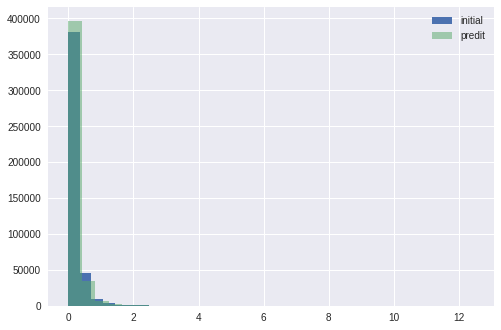

In [32]:
plt.hist(observed_Y, bins=30)
plt.hist(retrieved_Y,alpha = 0.5, bins=30)
plt.legend(['initial','predit'], loc='upper right');
plt.show()

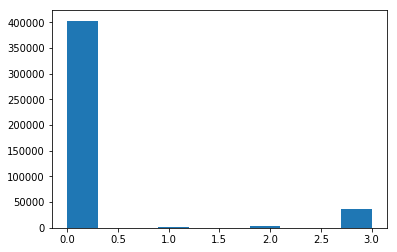

In [45]:
from sklearn.cluster import KMeans 
err=np.sqrt(sum((observed_Y-retrieved_Y)**2))
K=KMeans(4)
K.fit(observed_Y)
res=K.predict(observed_Y)
plt.hist(res)
plt.show()

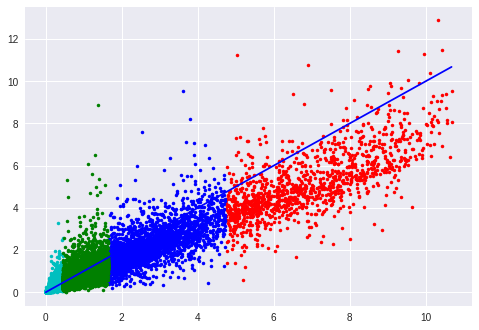

In [150]:
plt.plot(observed_Y[res==0],retrieved_Y[res==0],'c.')
plt.plot(observed_Y[res==1],retrieved_Y[res==1],'r.')
plt.plot(observed_Y[res==2],retrieved_Y[res==2],'b.')
plt.plot(observed_Y[res==3],retrieved_Y[res==3],'g.')
plt.plot(observed_Y[res==4],retrieved_Y[res==4],'y.')
plt.plot([min(observed_Y), max(observed_Y)], [min(observed_Y), max(observed_Y)], 'b-')
plt.show()

In [145]:
observed_Y[((observed_Y<6) & (retrieved_Y>8))]

array([ 5.02453276,  1.38440746,  3.79801232,  3.60760062])


Stats donnees Normalisees:
Calcule les erreurs entre deux matrices (Obs - Ret):
 Dimensions des matrices .............. ((444048, 1),(444048, 1))
 Erreur Quadratique ................... 136.572
 Erreur Quadratique Moyenne ........... 0.00030756
 RMS (Root Mean Squared Error) ........ 0.017537
 Bias = moyenne des erreurs ........... -0.0010143

Stats donnees Denormalisees:
Calcule les erreurs entre deux matrices (Obs - Ret):
 Dimensions des matrices .............. ((444048, 1),(444048, 1))
 Erreur Quadratique ................... 6945.471
 Erreur Quadratique Moyenne ........... 0.015641
 RMS (Root Mean Squared Error) ........ 0.12507
 Bias = moyenne des erreurs ........... -0.0021278
lax Avant: [-0.53486917685194824, 11.211650030065288, -0.62700797216272253, 13.084477625500917]
lax Apres: [-0.53486917685194824, 11.211650030065288, 0, 13.084477625500917] <type 'list'>
lax LOG Avant: [0.001, 100.0, 0.001, 100.0]
lax LOG Apres: [0.001, 100.0, 0.001, 30] <type 'list'>
sauvegarde de la figur

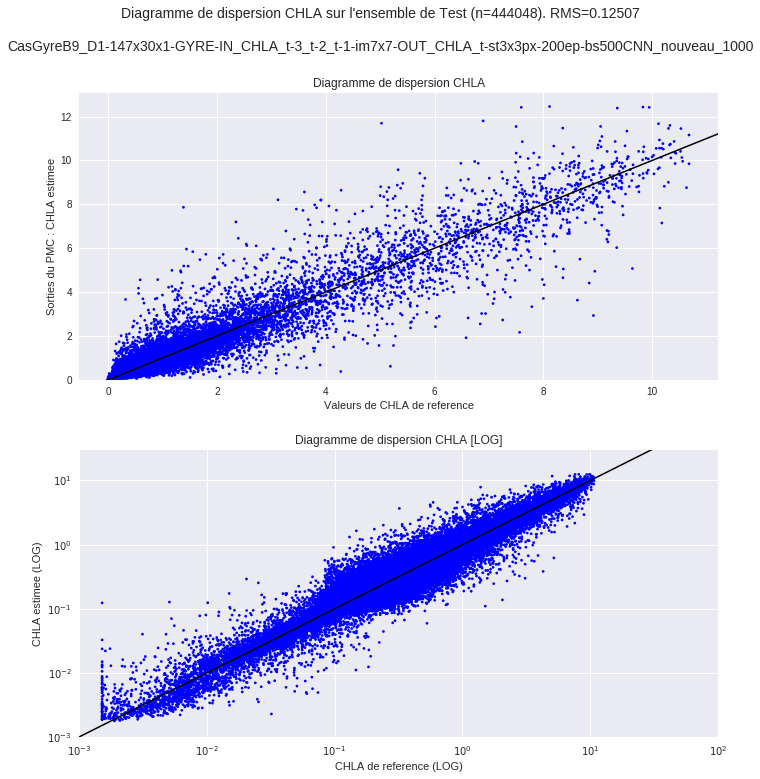

In [33]:
#%% --------------------------------------------------------------
# Diagramme de dipersion pour la regression avec les valeurs de sorties
# denormalisees avec les poids au minimum de la validation, sur l'ensemble de Test 
if current_key == 'CHLA' :
    aberrant_value_min_limit = 0
    aberrant_value_max_limit = 30
n_test_don = observed_Y.shape[0]
print("\nStats donnees Normalisees:")
errors_norm_data = calc_errors(current_y_test,current_y_out_test,verbose=True) # Err sur donnees Normalisees
print("\nStats donnees Denormalisees:")
errors_denorm_data= calc_errors(observed_Y,retrieved_Y,verbose=True) # Err sur donnees Denormalisees
errq_mv,errqm_mv,rms_mv,biais_mv = errors_denorm_data
# figure
fig = plt.figure(figsize=(10, 10),facecolor='w');    
plt.subplot(211)
plt.scatter(observed_Y, retrieved_Y, s=30, marker='.', c='b', edgecolors="None"); # plotter des points de taille 30
lax=plt.axis() # recupere les axes pour les remettre a la fin
print("lax Avant:",list(lax))
xlim=plt.xlim(); ylim=plt.ylim();
current_image_title = "Diagramme de dispersion "+current_key
# pour l'affichage, correction eventuelle des limites des axes pour ne pas afficher les valeurs
# "aberrants": des valeurs sortant de toute echelle realiste, qui applatissent les données affichées
if current_key == 'CHLA' :
    # pour la CHLA, a cause du codage en LOG, il est possible d'avoir au decodage des valeurs extremement elevees
    if lax[2] < aberrant_value_min_limit :
        lax = [lax[0],lax[1],aberrant_value_min_limit,lax[3]]
        n_aberrant_pix = (np.ndarray.flatten(retrieved_Y) < aberrant_value_min_limit).tolist().count(True)
        if n_aberrant_pix > 0 :
            print('==> {} valeurs retrouvees "aberrants" Min (< {})'.format(n_aberrant_pix,aberrant_value_min_limit))
            current_image_title += "\n{}/{} pixels masques car la valeur retrouvee est trop petite (< {}), (min={})".format(
                n_aberrant_pix,n_test_don,aberrant_value_min_limit,min(retrieved_Y))
    if lax[3] > aberrant_value_max_limit :
        lax = [lax[0],lax[1],lax[2],aberrant_value_max_limit]
        n_aberrant_pix = (np.ndarray.flatten(retrieved_Y) > aberrant_value_max_limit).tolist().count(True)
        if n_aberrant_pix > 0 :
            print('==> {} valeurs retrouvees "aberrants" Max (> {})'.format(n_aberrant_pix,aberrant_value_max_limit))
            current_image_title += "\n{}/{} pixels masques car la valeur retrouvee est trop importante (> {}), (max={})".format(
                n_aberrant_pix,n_test_don,aberrant_value_max_limit,max(retrieved_Y))
print("lax Apres:",list(lax),type(lax))
plt.axis(lax) # remet les axes eventuellement corriges
plt.plot([min(xlim[0],ylim[0]), max(xlim[1],ylim[1])],
         [min(xlim[0],ylim[0]), max(xlim[1],ylim[1])],
         linestyle='-', color=[0,0,0], linewidth=1.5);
plt.axis(lax) # remet les axes recuperes precedemment
plt.grid(True)
plt.xlabel('Valeurs de '+current_key+' de reference');
plt.ylabel('Sorties du PMC : '+current_key+' estimee'); 
plt.title(current_image_title, fontsize=12);
plt.subplot(212)
ax = plt.gca()
ax.scatter(observed_Y, retrieved_Y, s=30, marker='.', c='b', edgecolors="None"); # plotter des points de taille 30
ax.set_yscale('log')
ax.set_xscale('log')
#lax=plt.axis() # recupere les axes pour les remettre a la fin
#print("lax:",lax)
# bug avec la limites y des axes alors on les calcule manuellement:
lax = np.power(10.,[np.round(np.log10(min(observed_Y))), np.round(np.ceil(np.log10(max(observed_Y)))), 
       np.round(np.log10(min(retrieved_Y))), np.round(np.ceil(np.log10(max(retrieved_Y))))]).flatten().tolist()
print("lax LOG Avant:",list(lax))
# pour l'affichage, correction eventuelle des valeurs "aberrants": des valeurs sortant de toute echelle realiste
if current_key == 'CHLA' :
    # pour la CHLA, a cause du codage en LOG, il est possible d'avoir au decodage des valeurs extremement elevees
    if lax[2] < aberrant_value_min_limit :
        lax = [lax[0],lax[1],aberrant_value_min_limit,lax[3]]
    if lax[3] > aberrant_value_max_limit :
        lax = [lax[0],lax[1],lax[2],aberrant_value_max_limit]
print("lax LOG Apres:",list(lax),type(lax))
plt.axis(lax) # remet les axes recuperes precedemment
xlim=plt.xlim(); ylim=plt.ylim(); 
plt.plot([min(xlim[0],ylim[0]), max(xlim[1],ylim[1])],
         [min(xlim[0],ylim[0]), max(xlim[1],ylim[1])],
         linestyle='-', color=[0,0,0], linewidth=1.5);
plt.axis(lax) # remet les axes recuperes precedemment
plt.grid(True)
plt.xlabel(current_key+' de reference (LOG)');
plt.ylabel(current_key+' estimee (LOG)'); 
plt.title("Diagramme de dispersion "+current_key+" [LOG]", fontsize=12);
plt.tight_layout(h_pad=2.0) # pour augmenter la separation verticale entre axes de la meme figure
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.suptitle("Diagramme de dispersion "+current_key+" sur l'ensemble de "+\
          current_test_set+" (n={}). RMS={:2.5f}\n".format(n_test_don,rms_mv)+\
          "\n"+current_case_name,
          y=1.08, fontsize=14);
if save_figs_ok :
    fig_filename = figs_dirname+os.path.sep+"Fig_DiaDisp_"+current_case_name+'.png'
    print("sauvegarde de la figure des performances dans\n ",fig_filename)
    plt.savefig(fig_filename, bbox_inches='tight')
else :
    print("** sauvegarde des figures INACTIVE, diagramme de dispersion non sauve **")
plt.show()

lax LOG Avant: [0.001, 100.0, 0.001, 100.0]
lax LOG Apres: [0.001, 100.0, 0.001, 30] <type 'list'>
sauvegarde de la figure des performances dans
  Figs/CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px/Fig_DiaDisp_CasGyreB9_D1-147x30x1-GYRE-IN_CHLA_t-3_t-2_t-1-im7x7-OUT_CHLA_t-st3x3px-200ep-bs500CNN_nouveau_1000.png


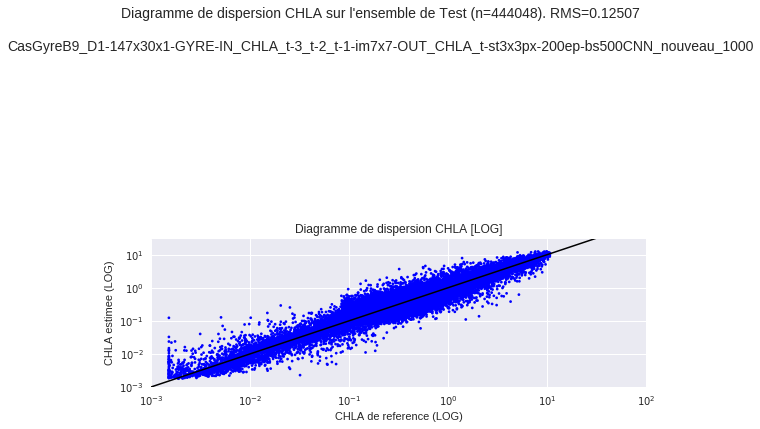

In [34]:
plt.axis(lax) # remet les axes eventuellement corriges
plt.plot([min(xlim[0],ylim[0]), max(xlim[1],ylim[1])],
         [min(xlim[0],ylim[0]), max(xlim[1],ylim[1])],
         linestyle='-', color=[0,0,0], linewidth=1.5);
plt.axis(lax) # remet les axes recuperes precedemment 
plt.grid(True)

plt.xlabel('Valeurs de '+current_key+' de reference');
plt.ylabel('Sorties du PMC : '+current_key+' estimee'); 
plt.title(current_image_title, fontsize=12);
plt.subplot(212)
ax = plt.gca()
ax.scatter(observed_Y, retrieved_Y, s=30, marker='.', c='b', edgecolors="None"); # plotter des points de taille 30
ax.set_yscale('log')
ax.set_xscale('log')
#lax=plt.axis() # recupere les axes pour les remettre a la fin
#print("lax:",lax)
# bug avec la limites y des axes alors on les calcule manuellement:
lax = np.power(10.,[np.round(np.log10(min(observed_Y))), np.round(np.ceil(np.log10(max(observed_Y)))), 
       np.round(np.log10(min(retrieved_Y))), np.round(np.ceil(np.log10(max(retrieved_Y))))]).flatten().tolist()
print("lax LOG Avant:",list(lax))
# pour l'affichage, correction eventuelle des valeurs "aberrants": des valeurs sortant de toute echelle realiste
if current_key == 'CHLA' :
    # pour la CHLA, a cause du codage en LOG, il est possible d'avoir au decodage des valeurs extremement elevees
    if lax[2] < aberrant_value_min_limit :
        lax = [lax[0],lax[1],aberrant_value_min_limit,lax[3]]
    if lax[3] > aberrant_value_max_limit :
        lax = [lax[0],lax[1],lax[2],aberrant_value_max_limit]
print("lax LOG Apres:",list(lax),type(lax))
plt.axis(lax) # remet les axes recuperes precedemment
xlim=plt.xlim(); ylim=plt.ylim(); 
plt.plot([min(xlim[0],ylim[0]), max(xlim[1],ylim[1])],
         [min(xlim[0],ylim[0]), max(xlim[1],ylim[1])],
         linestyle='-', color=[0,0,0], linewidth=1.5);
plt.axis(lax) # remet les axes recuperes precedemment
plt.grid(True)
plt.xlabel(current_key+' de reference (LOG)');
plt.ylabel(current_key+' estimee (LOG)'); 
plt.title("Diagramme de dispersion "+current_key+" [LOG]", fontsize=12);
plt.tight_layout(h_pad=2.0) # pour augmenter la separation verticale entre axes de la meme figure
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.suptitle("Diagramme de dispersion "+current_key+" sur l'ensemble de "+\
          current_test_set+" (n={}). RMS={:2.5f}\n".format(n_test_don,rms_mv)+\
          "\n"+current_case_name,
          y=1.08, fontsize=14);
if save_figs_ok :
    fig_filename = figs_dirname+os.path.sep+"Fig_DiaDisp_"+current_case_name+'.png'
    print("sauvegarde de la figure des performances dans\n ",fig_filename)
    plt.savefig(fig_filename, bbox_inches='tight')
else :
    print("** sauvegarde des figures INACTIVE, diagramme de dispersion non sauve **")
plt.show()


Normalisation des donnees TEST pour Image ...

norm_gyre_images:
Using external STAT PARAMS !
all_var_list: ['CHLA']
variables are arrays of 90 images of 180 x 270 pixels size

Normalizing CHLA :
local_norm_stat_params {'std': 0.31327477, 'log': True, 'min': -2.8188803, 'std_factor': 12, 'std_after_min': 0.31327471, 'absmin': 0.0015174681, 'normin': 0.01}
Normalisation par "normreduc": reduit la distribution des donnes et normalise
normreduc: using given statstruct: disregarding all other arguments:
   ==> [log, absmin, normin, std_factor] input arguments are disregarded.
normreduc: remplace 0 valeurs "trop petites" par le minimum absolut (0.00151746813208)

parametres specifies:
 log ............... True
 normin ............ 0.01
 absmin ............ 0.00151747
 std_factor ........ 12
Stats avant normalisation:
 min ............... 0.00151747
 max ............... 10.9053
 std ............... 0.454488
parametres calcules:
 st_min ............ -2.81888
 st_std ............ 0.313275
 st

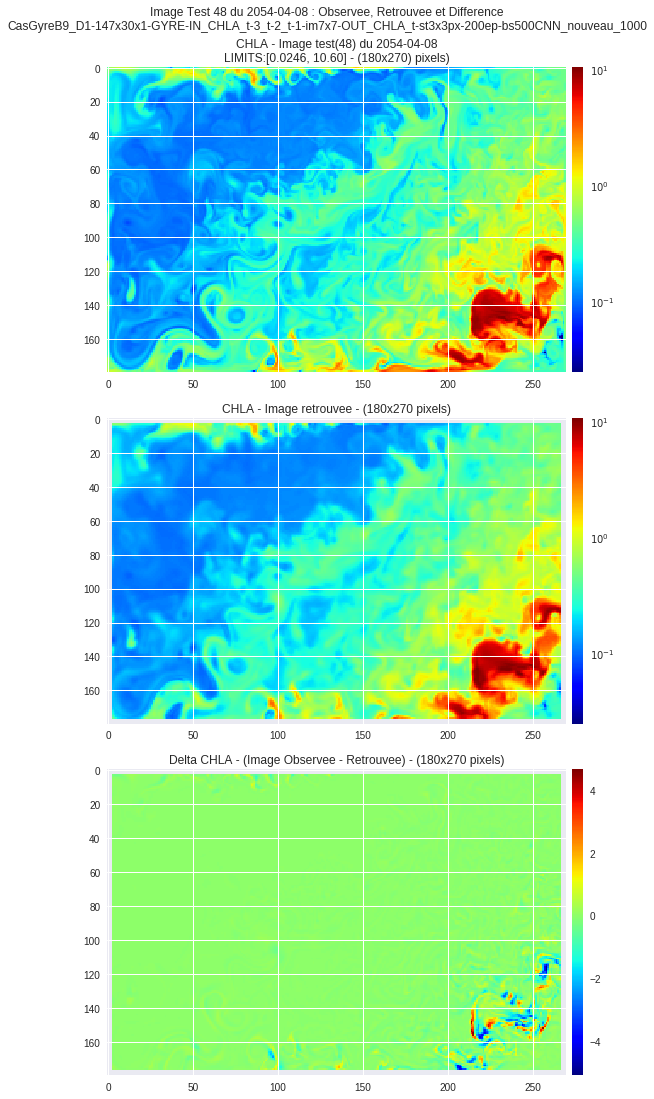

In [35]:
#%%
ima_index = 48 # pour TEST1 c'est le 2053-4-07

ima_date = datetime.date.fromordinal(gyre_test['time'][ima_index])

lgi.test_image(gyre_net, gyre_test, ima_index=ima_index, DD=DD, stat_params=case_stat_params, figsize=(12,14), timeDistributed_enable=True)
plt.suptitle("Image Test {} du {} : Observee, Retrouvee et Difference\n".format(ima_index,ima_date)+\
          current_case_name,
          y=1.06, fontsize=12);
if save_figs_ok :
    fig_filename = figs_dirname+os.path.sep+"Fig_TestIma_{}_du_{}-".format(ima_index,ima_date)+\
                        current_case_name+'.png'
    print("sauvegarde de la figure test des performances, image {} du {} dans\n {}".format(
            ima_index,ima_date,fig_filename))
    plt.savefig(fig_filename, bbox_inches='tight')
else :
    print("** sauvegarde des figures INACTIVE, diagramme de dispersion non sauve **")
plt.show();

In [ ]:
#%%
if 1:
    #nom_cas = case_name
    nom_cas = current_case_name
    print("\nCurrent case <"+nom_cas+"> files :")
    lgi.list_dir('.',regexp='*'+nom_cas+'*',silent=True)
    lgi.list_dir(net_dirname,regexp='*'+nom_cas+'*',title="Current Net files :",silent=True)
    lgi.list_dir(figs_dirname,regexp='*'+nom_cas+'*',title="Current Figs files :",silent=True)

Keys: ['CHLA', 'SST', 'SSTMW', 'lon', '__header__', '__globals__', 'SSTMERC', 'time', 'lat', 'SSHMERC', '__version__', 'SSTMWERROR']


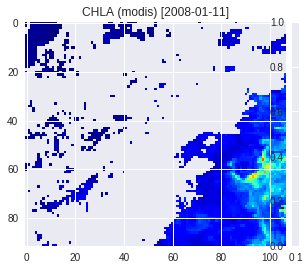


Normalisation des donnees TEST ...

norm_gyre_images:
Using external STAT PARAMS !
all_var_list: ['CHLA']
variables are arrays of 86 images of 92 x 107 pixels size

Normalizing CHLA :
local_norm_stat_params {'std': 0.31327477, 'log': True, 'min': -2.8188803, 'std_factor': 12, 'std_after_min': 0.31327471, 'absmin': 0.0015174681, 'normin': 0.01}
Normalisation par "normreduc": reduit la distribution des donnes et normalise
normreduc: using given statstruct: disregarding all other arguments:
   ==> [log, absmin, normin, std_factor] input arguments are disregarded.
normreduc: remplace 703569 valeurs "trop petites" par le minimum absolut (0.00151746813208)

parametres specifies:
 log ............... True
 normin ............ 0.01
 absmin ............ 0.00151747
 std_factor ........ 12
Stats avant normalisation:
 min ............... 0.00151746813208
 max ............... 63.0642745126
 std ............... 0.617725833021
parametres calcules:
 st_min ............ -2.81888
 st_std ............ 0

/opt/jupyter/anaconda3/envs/python2_venv/lib/python2.7/site-packages/ipykernel/__main__.py:188: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/opt/jupyter/anaconda3/envs/python2_venv/lib/python2.7/site-packages/ipykernel/__main__.py:189: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


In [88]:
###########################################################
################# Lecture données Test Réelles #################
###########################################################
from __future__ import print_function  # Armonise la syntaxe de print(), avec
                                       # des parentheses toujours.

from __future__ import division        # Eviter la division entiere accidentelle:
                                       # ainsi 1/2 n'est plus zero dans python2 !

from __future__ import absolute_import # Conseille ...


import matplotlib.pyplot as plt
#import matplotlib.colorbar as cb
from matplotlib import cm
from matplotlib.colors import LogNorm
import numpy as np
import scipy.io

def get_from_matlab_datenum(matlab_datenum):
    from datetime import datetime, timedelta
    python_datetime = datetime.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    return python_datetime

#import gzip
#try:
#    import pickle   # python 2
#except ImportError:
#    import cPickle as pickle   # python 3
from mpl_toolkits.axes_grid1 import make_axes_locatable

figsize = (12,14)

data_base_dirname = '../Donnees/DonneesTRIED/Gyre/real_data/'
filename = 'base_hiver_2008.mat'

don = scipy.io.loadmat(data_base_dirname+"/"+filename)

print('Keys: {}'.format(don.keys()))
lon =don['lon']
lat =don['lat']
chl =don['CHLA']
sst =don['SST']
sstmerc =don['SSTMERC']
sshmerc =don['SSHMERC']
sstmw =don['SSTMW']
time =don['time']

iimg = 10
cdate=get_from_matlab_datenum(time[iimg][0])
ldate=str(cdate.date())
fig = plt.figure(figsize=figsize,facecolor='w');    
plt.subplot(321)
lblimg = 'CHLA'
vimg = chl[iimg,:].copy()
vimg[vimg==0]=np.nan
#ims = plt.imshow(vimg, cmap=moncmap, norm=LogNorm(vmin=np.min(dbgimg[:]), vmax=np.max(dbgimg[:])))
ims = plt.imshow(vimg, cmap=cm.jet)
plt.title('{} (modis) [{}]'.format(lblimg,ldate))
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "3%", pad="2%")
#plt.colorbar(ims, cax=cax, orientation='vertical')
#plt.colorbar(ims, orientation='horizontal',pad=0.08,aspect=30)
#plt.subplot(322)
#lblimg = 'SST'
#vimg = sst[iimg,:]
#ims = plt.imshow(vimg, cmap=cm.jet, vmin=np.nanmin(vimg), vmax=np.nanmax(vimg))
#plt.title(lblimg+' (modis)')
#divider = make_axes_locatable(plt.gca())
#cax = divider.append_axes("right", "3%", pad="2%")
#plt.colorbar(ims, cax=cax, orientation='vertical')
#plt.subplot(324)
#lblimg = 'SST'
#vimg = sstmw[iimg,:]
#ims = plt.imshow(vimg, cmap=cm.jet, vmin=np.nanmin(vimg), vmax=np.nanmax(vimg))
#plt.title(lblimg+' (mw)')
#divider = make_axes_locatable(plt.gca())
#cax = divider.append_axes("right", "3%", pad="2%")
#plt.colorbar(ims, cax=cax, orientation='vertical')
#plt.subplot(325)
#lblimg = 'SSH'
#vimg = sshmerc[iimg,:]
#ims = plt.imshow(vimg, cmap=cm.jet, vmin=np.min(vimg), vmax=np.max(vimg))
#plt.title(lblimg+' (merc)')
#divider = make_axes_locatable(plt.gca())
#cax = divider.append_axes("right", "3%", pad="2%")
#plt.colorbar(ims, cax=cax, orientation='vertical')
#plt.subplot(326)
#lblimg = 'SST'
#vimg = sstmerc[iimg,:]
#ims = plt.imshow(vimg, cmap=cm.jet, vmin=np.min(vimg), vmax=np.max(vimg))
#plt.title(lblimg+' (merc)')
#divider = make_axes_locatable(plt.gca())
#cax = divider.append_axes("right", "3%", pad="2%")
#plt.colorbar(ims, cax=cax, orientation='vertical')
plt.show()

##### Paramètres
datalib='../Donnees/DonneesTRIED/Gyre/real_data/'

TEST_SET_OK = True
# INPUT variable list (choose between 'CHLA','SST','SSH','SSS')
in_var_list = 'CHLA'
#in_var_list = 'SST'
#in_var_list = ['CHLA','SST']
#in_var_list = ['CHLA','SST','SSH','SSS']
# ------------------------------------------------------------------------
# OUTPUT variable list (choose between 'CHLA','SST','SSH','SSS')
# Le meme qu'en Entree:
out_var_list = in_var_list
# ------------------------------------------------------------------------
gyre_norm_params = {'CHLA': { 'method':'normreduc', 'std_factor':12, 'log':True}, 
                    'SST':  { 'method':'normreduc', 'std_factor':4 },
                    'SSH':  { 'method':'normreduc', 'std_factor':6 },
                    'SSS':  { 'method':'normreduc', 'std_factor':4.5}}
# ------------------------------------------------------------------------
# Choose the Delta T for selecting INPUT IMAGES:
# Vecteur d'indices de decalage dans le temps (t-3, t-2, t, t-1) --> [-3, -2, -1]
t_decal_in = [-3, -2, -1];  # (t-3, t-2, t-1)
# ------------------------------------------------------------------------
t_decal_out = [0];  # (t)

# ========================================================================
# parametres de configuration imagettes a extraire
# ========================================================================

# tuple de la taille des imagettes en pixels
current_archi_in_imsize = (7,7)
#
im_l_in_sz,im_c_in_sz = current_archi_in_imsize; # separe les tailles L et C (lignes et colonnes)
# ------------------------------------------------------------------------
# le pas ou "step" de mouvement des fenêtres de selection des imagettes lors du
# sous-echantillonage des image source, HORIZ et VERT, en pixels, est de:
stp_value = im_l_in_sz//2; # un pas qui correspond à la moitie de la taille des imagettes, par exemple
#stp_value = 1;
#stp_value = 10;

#keys=['CHLA']
#, 'SST', 'SSTMW', 'lon', '__header__', '__globals__', 'SSTMERC', 'time', 'lat', 'SSHMERC', '__version__', 'SSTMWERROR'
#chld=dict(zip(keys, chl))
#gyre_data=chld
gyre_data=don

#%% Lecture des donnees Gyre pour TEST
if TEST_SET_OK :
#    print("\nChargement des données Gyre pour TEST ..." )
#    gyre_data_test = lgi.read_gyre_data(input_datalib=datalib,input_part_name=test_part_name)
    #
    # Normalisation des donnees TEST
    case_stat_params = gyre_stat_vars
    print("\nNormalisation des donnees TEST ...")
    gyre_norm_data_test,gyre_stat_vars_test = lgi.norm_gyre_images(gyre_data,
                                            in_var_list=in_var_list, out_var_list=out_var_list,
                                            norm_stat_params=case_stat_params)   # passe les parametres stat pour une
                                                                                 # normalisation a l'identique
    #
    print("\nExtraction des imagettes TEST {} ...".format(current_archi_in_imsize))
    DD_test = lgi.get_gyre_imagettes(gyre_norm_data_test,
                        in_var_list=in_var_list, out_var_list=out_var_list,
                        t_decal_in=t_decal_in, t_decal_out=t_decal_out,
                        stp_value=stp_value,
                        imgtt_l_size_in=im_l_in_sz,
                        imgtt_c_size_in=im_c_in_sz,
                        silent=False);
    #
    # ========================================================================
    # Recupere les donnees x_test et y_test (imagettes)
    x_test = DD_test['x_img_train'];     # imagettes d'Entree
    #yi_test = DD_test['y_img_train'];    # imagettes de Sortie (pas utilisees)
    y_test = DD_test['y_vec_train'];     # vecteur de Sortie
    

DATA_TEST_REAL=1

L=[]
for i in range (x_test.shape[0]):
    if (np.any(x_test[i,:,3,3]==0)):
        L.append(i)
len(L)
x_test=np.delete(x_test, (L), axis=0)
y_test=np.delete(y_test, (L), axis=0)
K=[]
for i in range (x_test.shape[0]):
    for j in range(x_test.shape[1]):
        if ((x_test[i,j,:,:]==0).sum())>15:
            K.append(i)
K=np.unique(K)
x_test=np.delete(x_test, (K), axis=0)
y_test=np.delete(y_test, (K), axis=0)

for i in range (x_test.shape[0]):
    for j in range(x_test.shape[1]):
        v=[]
        for m in range (x_test.shape[2]):
            for n in range(x_test.shape[3]):
                if (np.invert((x_test[i,j,m,n]==0))):
                    v=x_test[i,j,m,n]
        vmoy=np.mean(v)
        for m in range (x_test.shape[2]):
            for n in range(x_test.shape[3]):
                if ((x_test[i,j,m,n]==0)):
                    x_test[i,j,m,n]=vmoy

In [89]:
x_test2=x_test
x_test2=x_test2.reshape([x_test2.shape[0],3,1,nx,ny])

In [90]:
x_test_array = x_test2
y_test_array = y_test
y_out_test_array=gyre_net.predict(x_test_array)

Calcule les erreurs entre deux matrices (Obs - Ret):
 Dimensions des matrices .............. ((81838, 1),(81838, 1))
 Erreur Quadratique ................... 5104.972
 Erreur Quadratique Moyenne ........... 0.062379
 RMS (Root Mean Squared Error) ........ 0.24976
 Bias = moyenne des erreurs ........... 0.10787
Erreurs de Kullback:
 Erreurs de Kullback .......... 46124.309
Erreurs de Correlation:
 Erreurs de Correlation .......... 0.116
Erreurs de l'angle par rapport a la bisectrice:
 Erreurs de l'angle par rapport a la bisectrice .......... 0.995


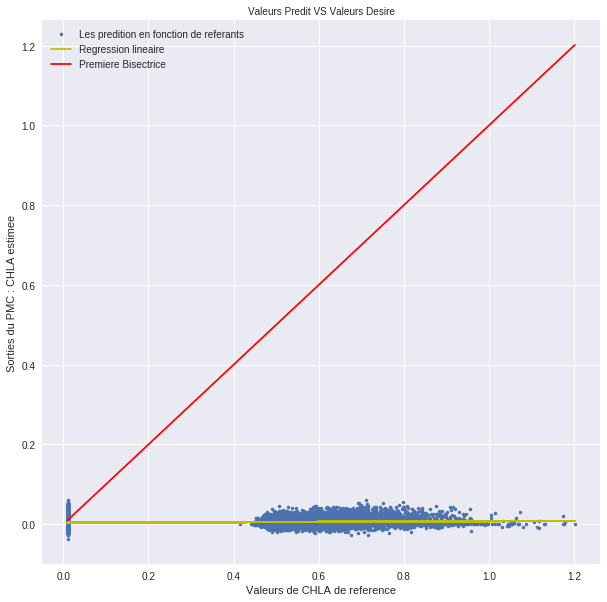

0.99490544590054353

In [91]:
calc_errors(y_test_array,y_out_test_array,verbose=True) # Err sur donnees Normalisees
calc_errors_kullback(y_test_array,y_out_test_array,verbose=True)
calc_errors_corr(y_test_array,y_out_test_array,verbose=True)
calc_errors_angle(y_test_array,y_out_test_array,verbose=True)

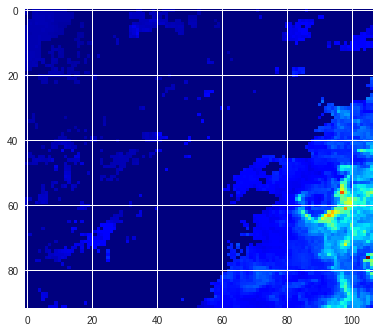

In [81]:
iin=10
ims = plt.imshow(chl[iin,:], cmap=cm.jet)
plt.show()

In [ ]:
for i in range (x_test.shape[0]):
    if (np.any(np.isnan(x_test[i,:,3,3]))):
        L.append(i)
len(L)
x_test=np.delete(x_test, (L), axis=0)
y_test=np.delete(y_test, (L), axis=0)
K=[]
for i in range (x_test.shape[0]):
    for j in range(x_test.shape[1]):
        if (np.isnan(x_test[i,j,:,:]).sum())>15:
            K.append(i)
K=np.unique(K)
x_test=np.delete(x_test, (K), axis=0)
y_test=np.delete(y_test, (K), axis=0)

for i in range (x_test.shape[0]):
    for j in range(x_test.shape[1]):
        v=[]
        for m in range (x_test.shape[2]):
            for n in range(x_test.shape[3]):
                if (np.invert(np.isnan(x_test[i,j,m,n]))):
                    v=x_test[i,j,m,n]
        vmoy=np.mean(v)
        for m in range (x_test.shape[2]):
            for n in range(x_test.shape[3]):
                if (np.isnan(x_test[i,j,m,n])):
                    x_test[i,j,m,n]=vmoy